In [1]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as plt
sc.settings.verbosity = 3
sc.logging.print_header()
sc.set_figure_params(dpi=100, dpi_save=600)

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display

import base64
import glob
import json
import loompy as lp
import os
import scipy
import zlib

from matplotlib import rcParams
from adjustText import adjust_text

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 pynndescent==0.5.5


In [2]:
# set a working directory
wdir = "C:/Users/Park_Lab/Documents/"
os.chdir(wdir)

# path to loom file with basic filtering applied (this will be created in the "initial filtering" step below).
f_loom_path_scenic = "C:/Users/Park_Lab/Documents/MSO_4in1_filtered_for_scenic.loom"

In [3]:
# create these folders manually
AUXILLIARIES_FOLDERNAME = "C:/Users/Park_Lab/Documents/auxilliaries/"
RESULTS_FOLDERNAME = "C:/Users/Park_Lab/Documents/MSO_4in1/results/"
FIGURES_FOLDERNAME = "C:/Users/Park_Lab/Documents/MSO_4in1/figures/"
sc.settings.figdir = FIGURES_FOLDERNAME

In [4]:
# Auxilliary functions
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

In [5]:
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

In [6]:
def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [7]:
# Auxilliary data sets, put the files into coresponding folders
Mouse_TFS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'mm_mgi_tfs.txt')
RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                       ['mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.feather','mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather']))
MOTIF_ANNOTATIONS_FNAME = os.path.join(AUXILLIARIES_FOLDERNAME, 'motifs-v9-nr.mgi-m0.001-o0.0.tbl')

In [8]:
# input resources
DATASET_ID = "MSO_4in1"
TCGA_CODE = 'mouse_stomach'

In [ ]:
WT = sc.read_10x_mtx('D:/ZGY/MSO_matrix/WT/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True) 

In [10]:
WT.var_names_make_unique()
WT

AnnData object with n_obs × n_vars = 1822 × 32285
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [ ]:
KO = sc.read_10x_mtx('D:/ZGY/MSO_matrix/KO/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True) 

In [11]:
KO.var_names_make_unique()
KO

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [12]:
KP = sc.read_10x_mtx('D:/ZGY/MSO_matrix/KP/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True) 

AnnData object with n_obs × n_vars = 1939 × 32285
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [ ]:
KP.var_names_make_unique()
KP

In [13]:
CKP = sc.read_10x_mtx('D:/ZGY/MSO_matrix/CKP/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True) 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
CKP.var_names_make_unique()
CKP

AnnData object with n_obs × n_vars = 2115 × 32285
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [17]:
adata = WT.concatenate(KO, KP, CKP, batch_categories=['WT', 'KO', 'KP', 'CKP'])
adata

AnnData object with n_obs × n_vars = 7867 × 32285
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [18]:
# create Results path
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.adjacencies.tsv'.format(DATASET_ID))
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.motifs.csv'.format(DATASET_ID))
REGULONS_DAT_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.regulons.dat'.format(DATASET_ID))
AUCELL_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.aucell.csv'.format(DATASET_ID))
BINARY_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.binary.csv'.format(DATASET_ID))
THR_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.thresholds.csv'.format(DATASET_ID))
ANNDATA_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}.h5ad'.format(DATASET_ID))
LOOM_FNAME = os.path.join(RESULTS_FOLDERNAME, '{}_{}.loom'.format(TCGA_CODE, DATASET_ID))

In [19]:
# STEP 0: Preprocessing

normalizing counts per cell
    finished (0:00:00)


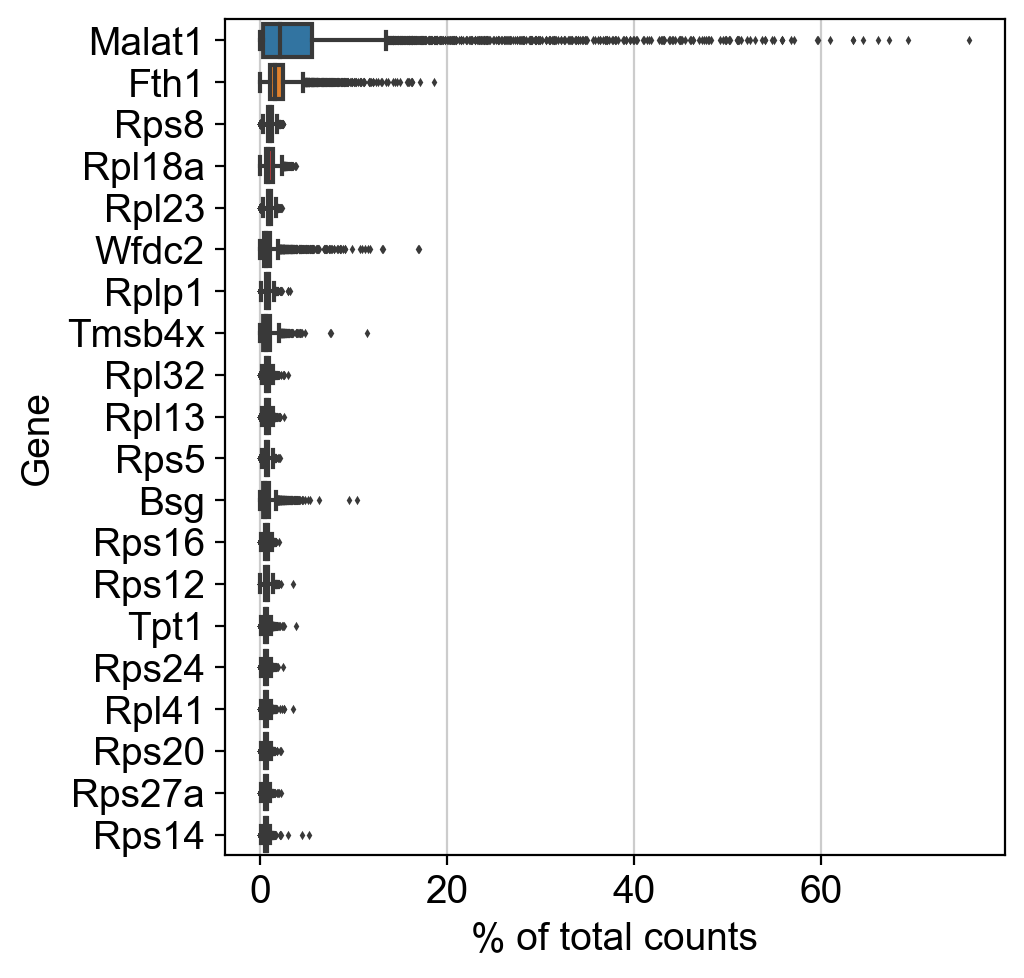

filtered out 17383 genes that are detected in less than 5 cells


C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Chromosome' as categorical
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Strand' as categorical


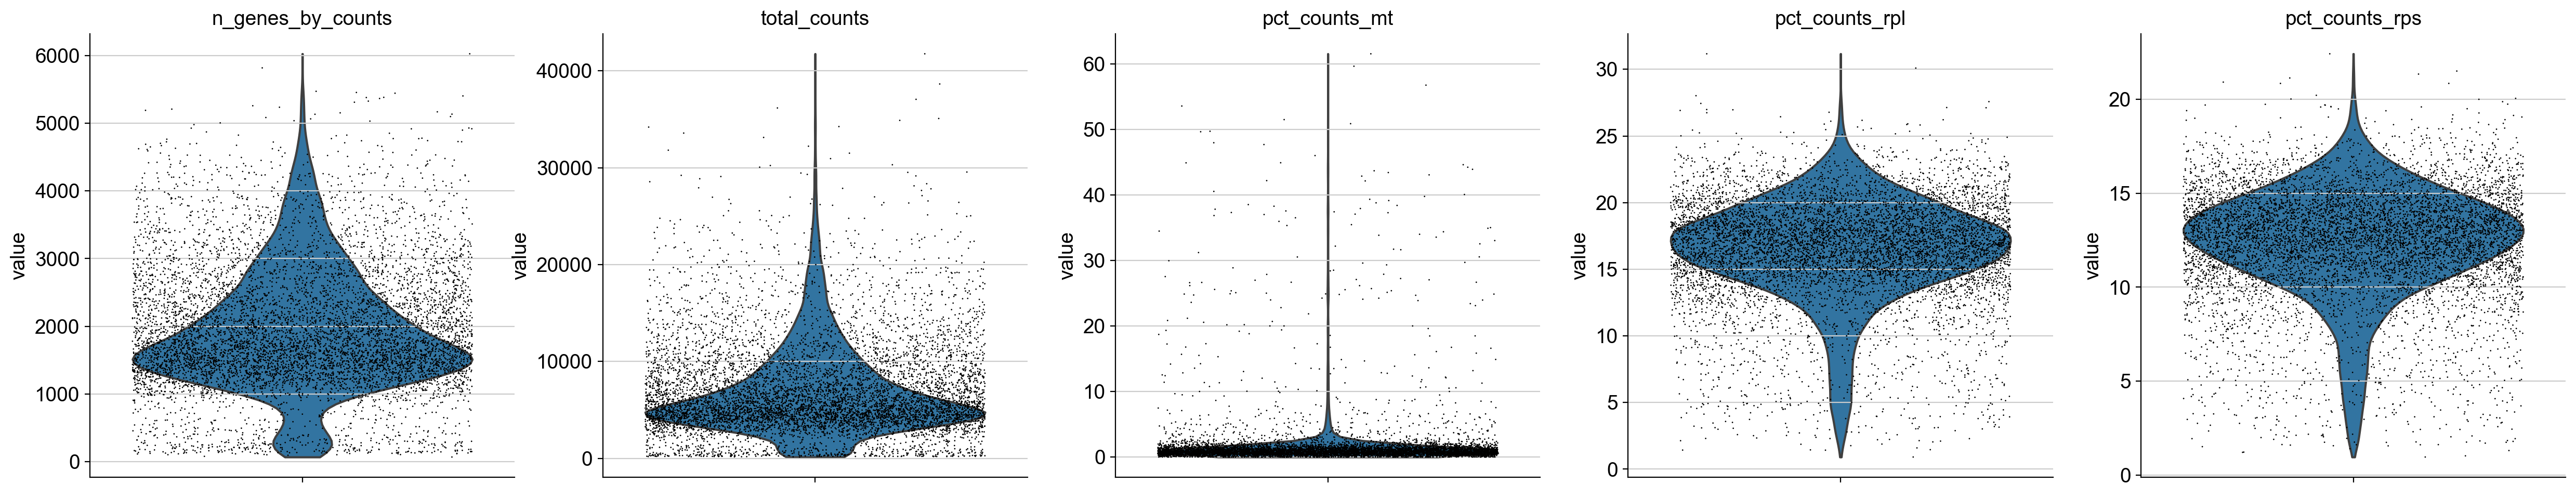

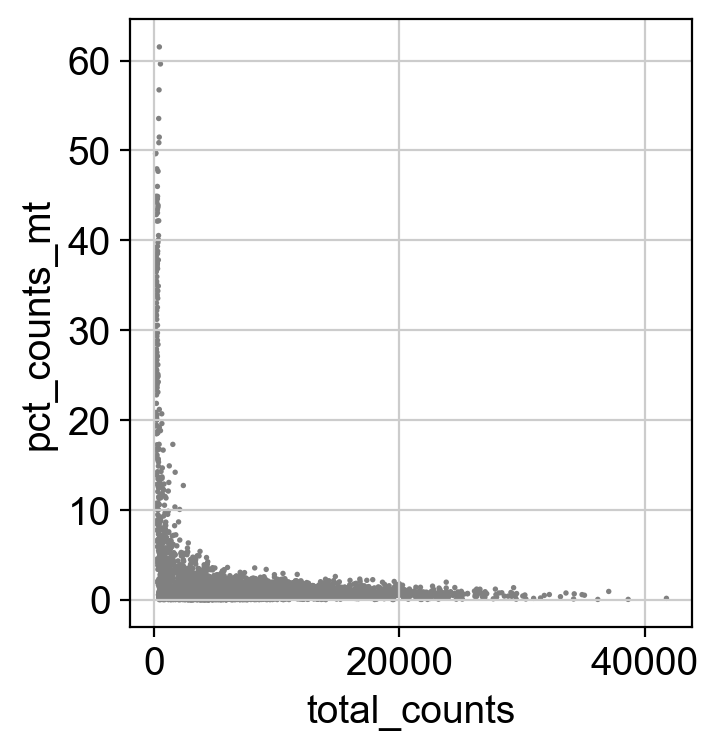

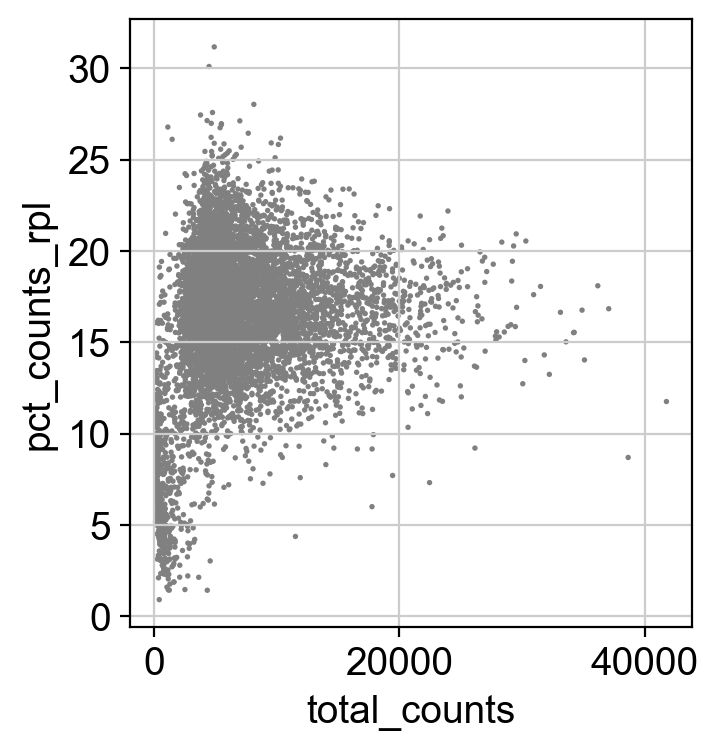

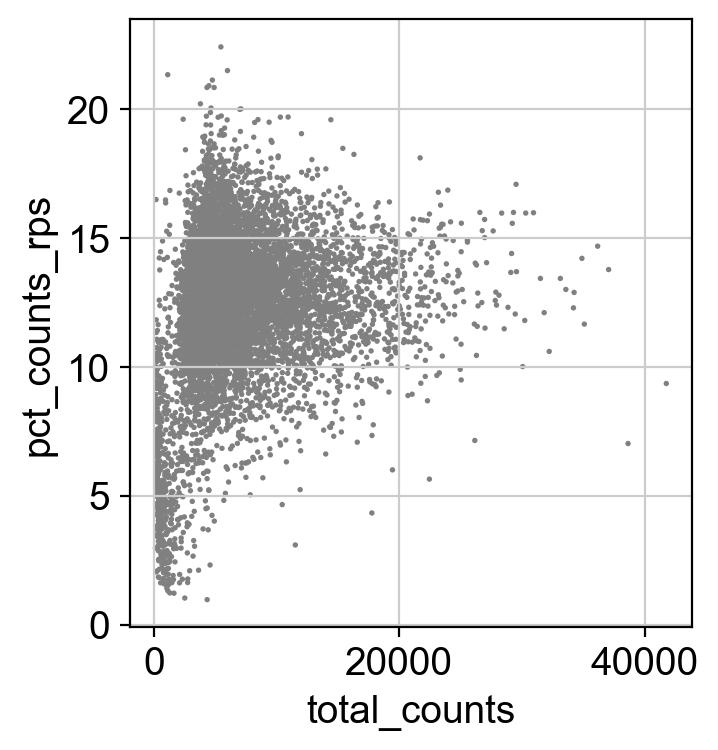

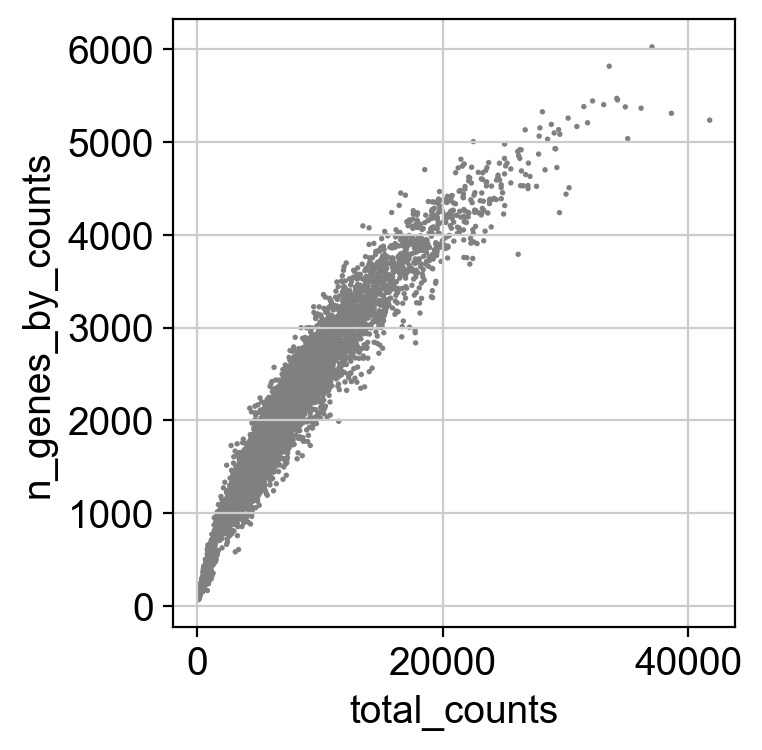

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=5)
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['rpl'] = adata.var_names.str.startswith('Rpl')
adata.var['rps'] = adata.var_names.str.startswith('Rps')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','rpl','rps'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_rpl','pct_counts_rps'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_rpl')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_rps')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.pct_counts_mt < 50, :]
adata = adata[adata.obs.pct_counts_rpl < 50, :]
adata = adata[adata.obs.pct_counts_rps < 50, :]

In [21]:
# Output the basic filtered expression matrix to f_loom_path_scenic
row_attrs = {"Gene": np.array(adata.var_names)}
col_attrs = {"CellID": np.array(adata.obs_names), "nGene": np.array(np.sum(adata.X.transpose()>0, axis=0)).flatten(),
             "nUMI": np.array(np.sum(adata.X.transpose(), axis=0)).flatten()}
lp.create(f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)
# key step, after basic filtering, save into f_loom_path_scenic instead of the data after Scanpy proceedingfor SCENIC 

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


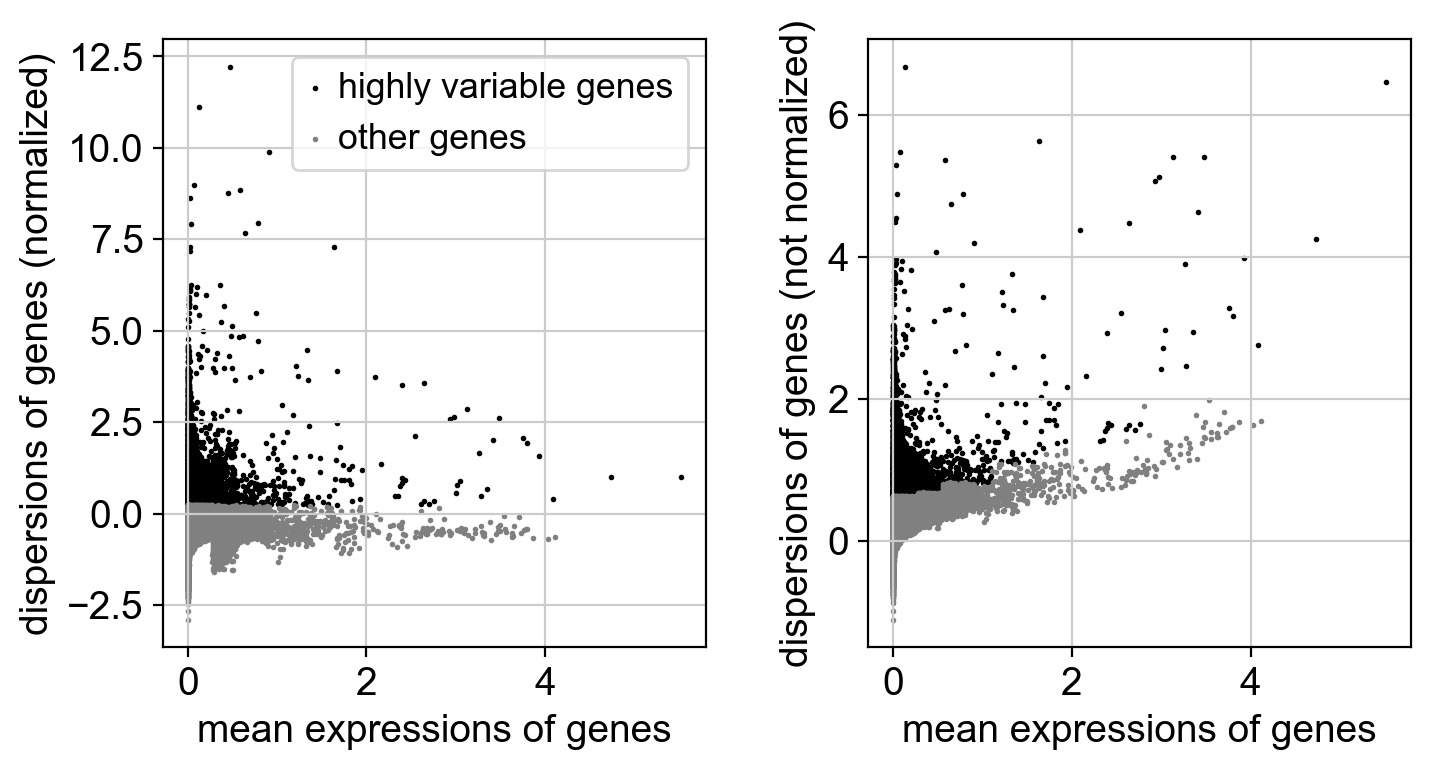

5000
regressing out ['pct_counts_mt', 'pct_counts_rpl', 'pct_counts_rps']
    sparse input is densified and may lead to high memory use
    finished (0:00:18)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


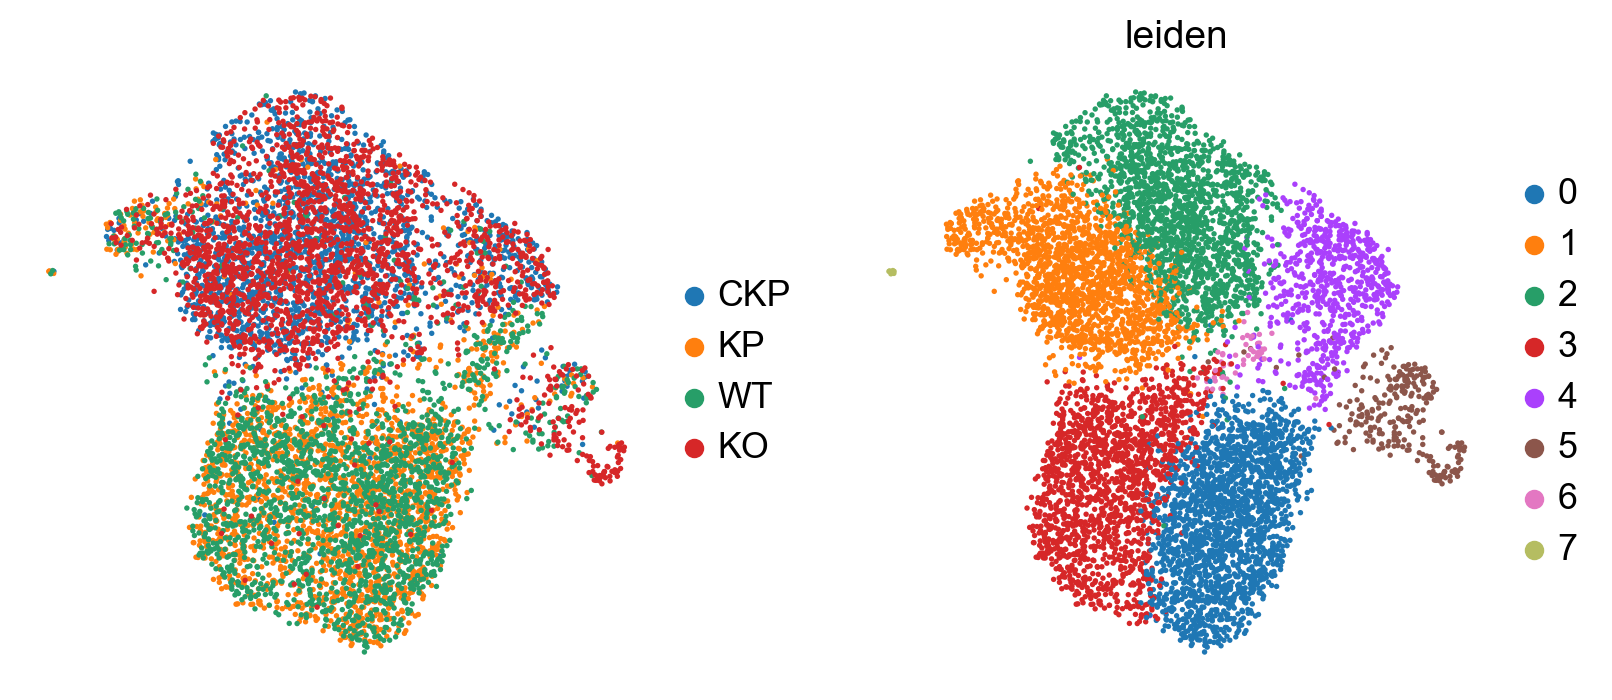

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
sc.pl.highly_variable_genes(adata)
print(sum(adata.var.highly_variable))
adata.raw=adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, keys=['total_counts', 'pct_counts_mt','pct_counts_rpl','pct_counts_rps'], n_jobs=16)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sce.pp.harmony_integrate(adata, key='batch', basis='X_pca', adjusted_basis='X_pca_harmony')
adata.obsm['X_pca']=adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, knn=True)
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)
adata

In [ ]:
sc.pl.umap(adata, color=['batch'], legend_loc='right margin', frameon=False, title='', use_raw=True,
           palette={'WT': 'purple', 'KO': 'blue', 'KP': 'green', 'CKP': 'red'}, save='1.pdf')
sc.pl.umap(adata, color=['leiden'], legend_loc='right margin', frameon=False, title='', use_raw=True, palette='Accent')

In [20]:
# create adata.obs['pca_leiden'] to store leiden cluster names determined by pca, because later aucell based embedding will cover adata.obs['leiden']
adata.obs['pca_leiden'] = adata.obs['leiden']
adata.uns['pca_leiden_colors'] = adata.uns['leiden_colors']

In [23]:
# STEP 1: Gene regulatory network inference, and module generation

In [24]:
%%time
!pyscenic grn {f_loom_path_scenic} {Mouse_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 16

preparing dask client
parsing input
creating dask graph
16 partitions
computing dask graph
not shutting down client, client was created externally
finished
Wall time: 3h 27min 36s



2022-02-14 00:32:16,324 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-02-14 00:32:17,699 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55578 instead
  warnings.warn(

2022-02-14 03:59:33,079 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [25]:
# STEP 2-3: Motif enrichment and TF-regulon prediction

In [26]:
DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)

In [27]:
%%time
!pyscenic ctx {ADJACENCIES_FNAME} {DBS_PARAM} \
            --annotations_fname {MOTIF_ANNOTATIONS_FNAME} \
            --expression_mtx_fname {f_loom_path_scenic} \
            --output {MOTIFS_FNAME} \
            --num_workers 16
# The results is a list of enriched motifs for the modules


[                                        ] | 0% Completed |  0.0s
[                                        ] | 0% Completed |  0.1s
[                                        ] | 0% Completed |  0.3s
[                                        ] | 0% Completed |  0.5s
[                                        ] | 0% Completed |  0.6s
[                                        ] | 0% Completed |  0.7s
[                                        ] | 0% Completed |  0.9sWall time: 26min 27s
[                                        ] | 0% Completed |  1.1s
[                                        ] | 0% Completed |  1.3s
[                                        ] | 0% Completed |  1.5s
[                                        ] | 0% Completed |  1.6s
[                                        ] | 0% Completed |  1.8s
[                                        ] | 0% Completed |  1.9s
[                                        ] | 0% Completed |  2.1s
[                                        ] | 0% Complet


2022-02-14 03:59:52,517 - pyscenic.cli.pyscenic - INFO - Creating modules.

2022-02-14 03:59:54,064 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-02-14 03:59:55,876 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-02-14 03:59:56,751 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-02-14 04:01:00,000 - pyscenic.utils - INFO - Creating modules.

2022-02-14 04:02:46,777 - pyscenic.cli.pyscenic - I

[                                        ] | 0% Completed |  3.6s
[                                        ] | 0% Completed |  3.8s
[                                        ] | 0% Completed |  4.0s
[                                        ] | 0% Completed |  4.1s
[                                        ] | 0% Completed |  4.2s
[                                        ] | 0% Completed |  4.4s
[                                        ] | 0% Completed |  4.5s
[                                        ] | 0% Completed |  4.8s
[                                        ] | 0% Completed |  5.0s
[                                        ] | 0% Completed |  5.3s
[                                        ] | 0% Completed |  5.4s
[                                        ] | 0% Completed |  5.6s
[                                        ] | 0% Completed |  5.7s
[                                        ] | 0% Completed |  5.8s
[                                        ] | 0% Completed |  6.0s
[         

2022-02-14 04:05:45,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Cptp could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:05:47,126 - pyscenic.transform - WARNING - Less than 80% of the genes in Rfx3 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:05:47,329 - pyscenic.transform - WARNING - Less than 80% of the genes in Rfx5 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:05:48,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Rlf could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:05:48,470 - pyscenic.transform - WARNING - Less than 80% of the genes in Rnf114 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:05:48,642 - pyscenic.transform - WARNING - Less th

In [28]:
# Column name	Description
# TF	Transcription Factor (TF) for which an enriched motif is discovered.
# motifID	The identifier of the enriched motif.
# AUC	Area Under the recovery Curve statistic for this enriched motif.
# NES	Normalized Enrichment Score for this enriched motif.
# Context	Collection of tags clarifying the origin of the module for this factor: e.g. ranking database, ...
# Annotation	Verbose description of the annotation available for this motif.
# MotifSimilarityQvalue	The TomTom derived Q-value for motif similarity (if used for assigning the factor to this enriched motif).
# OrthologousIdentity	The Amino Acid Identity between factors (if used for assigning the factor to this enriched motif).
# RankAtMax	The position of the Leading Edge which is used as a threshold on the whole genome ranking of the motif to decide if a gene in the input is a direct target of a TF that binds this motif.
# TargetGenes	A list of pairs: genes and their associated weights from GRNBoost2.

[                                        ] | 0% Completed | 42.8s
[                                        ] | 0% Completed | 42.9s
[                                        ] | 0% Completed | 43.0s
[                                        ] | 0% Completed | 43.2s
[                                        ] | 0% Completed | 43.3s
[                                        ] | 0% Completed | 43.4s
[                                        ] | 0% Completed | 43.5s
[                                        ] | 0% Completed | 43.6s
[                                        ] | 0% Completed | 43.7s
[                                        ] | 0% Completed | 43.9s
[                                        ] | 0% Completed | 44.0s
[                                        ] | 0% Completed | 44.1s
[                                        ] | 0% Completed | 44.2s
[                                        ] | 0% Completed | 44.3s
[                                        ] | 0% Completed | 44.4s
[         

In [29]:
df_motifs = load_motifs(MOTIFS_FNAME)


2022-02-14 04:10:04,286 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp27 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:10:04,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp276 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:10:05,067 - pyscenic.transform - WARNING - Less than 80% of the genes in Nfe2l3 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:10:05,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp281 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:10:05,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp282 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:10:05,801 - pyscenic.transform - WARNING 

[                                        ] | 0% Completed |  2min 17.3s
[                                        ] | 0% Completed |  2min 17.5s
[                                        ] | 0% Completed |  2min 17.6s
[                                        ] | 0% Completed |  2min 17.7s
[                                        ] | 0% Completed |  2min 17.8s
[                                        ] | 0% Completed |  2min 18.0s
[                                        ] | 0% Completed |  2min 18.1s
[                                        ] | 0% Completed |  2min 18.2s
[                                        ] | 0% Completed |  2min 18.3s
[                                        ] | 0% Completed |  2min 18.5s
[                                        ] | 0% Completed |  2min 18.6s
[                                        ] | 0% Completed |  2min 18.7s
[                                        ] | 0% Completed |  2min 18.8s
[                                        ] | 0% Completed |  2mi


2022-02-14 04:12:12,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Ruvbl1 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:12:14,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp28 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:12:18,079 - pyscenic.transform - WARNING - Less than 80% of the genes in Mecp2 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:12:18,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Med30 could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:12:18,548 - pyscenic.transform - WARNING - Less than 80% of the genes in Mef2c could be mapped to mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2022-02-14 04:12:18,704 - pyscenic.transform - WARNING - L


[                                        ] | 0% Completed |  4min 33.6s
[                                        ] | 0% Completed |  4min 33.7s
[                                        ] | 0% Completed |  4min 33.8s
[                                        ] | 0% Completed |  4min 33.9s
[                                        ] | 0% Completed |  4min 34.0s
[                                        ] | 0% Completed |  4min 34.2s
[                                        ] | 0% Completed |  4min 34.3s
[                                        ] | 0% Completed |  4min 34.4s
[                                        ] | 0% Completed |  4min 34.6s
[                                        ] | 0% Completed |  4min 34.7s
[                                        ] | 0% Completed |  4min 34.8s
[                                        ] | 0% Completed |  4min 34.9s
[                                        ] | 0% Completed |  4min 35.0s
[                                        ] | 0% Completed |  4m

2022-02-14 04:21:12,709 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp354a could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:12,805 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp362 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:12,977 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp37 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:13,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp383 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:13,180 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp384 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:13,305 - pyscenic.transform - WARNING - Less than 80% of the genes in Jdp

[                                        ] | 0% Completed |  6min 31.0s
[                                        ] | 0% Completed |  6min 31.1s
[                                        ] | 0% Completed |  6min 31.2s
[                                        ] | 0% Completed |  6min 31.4s
[                                        ] | 0% Completed |  6min 31.5s
[                                        ] | 0% Completed |  6min 31.7s
[                                        ] | 0% Completed |  6min 31.8s
[                                        ] | 0% Completed |  6min 31.9s
[                                        ] | 0% Completed |  6min 32.0s
[                                        ] | 0% Completed |  6min 32.2s
[                                        ] | 0% Completed |  6min 32.3s
[                                        ] | 0% Completed |  6min 32.4s
[                                        ] | 0% Completed |  6min 32.6s
[                                        ] | 0% Completed |  6mi


2022-02-14 04:21:32,773 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp729a could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:32,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp729b could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:33,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp760 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:33,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp764 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:33,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp768 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:33,288 - pyscenic.transform - WARNING - Less than 80% of the genes in 


[                                        ] | 0% Completed |  6min 46.8s
[                                        ] | 0% Completed |  6min 46.9s
[                                        ] | 0% Completed |  6min 47.0s
[                                        ] | 0% Completed |  6min 47.1s
[                                        ] | 0% Completed |  6min 47.3s
[                                        ] | 0% Completed |  6min 47.4s
[                                        ] | 0% Completed |  6min 47.5s
[                                        ] | 0% Completed |  6min 47.6s
[                                        ] | 0% Completed |  6min 47.8s
[                                        ] | 0% Completed |  6min 47.9s
[                                        ] | 0% Completed |  6min 48.0s
[                                        ] | 0% Completed |  6min 48.1s
[                                        ] | 0% Completed |  6min 48.2s
[                                        ] | 0% Completed |  6m


2022-02-14 04:21:42,228 - pyscenic.transform - WARNING - Less than 80% of the genes in Ppp2r3d could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:42,306 - pyscenic.transform - WARNING - Less than 80% of the genes in Prdm1 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:42,369 - pyscenic.transform - WARNING - Less than 80% of the genes in Prdm16 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:42,400 - pyscenic.transform - WARNING - Less than 80% of the genes in Foxo6 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:42,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Prdx5 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:44,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfx 


[                                        ] | 0% Completed |  6min 59.0s
[                                        ] | 0% Completed |  6min 59.1s
[                                        ] | 0% Completed |  6min 59.2s
[                                        ] | 0% Completed |  6min 59.4s
[                                        ] | 0% Completed |  6min 59.5s
[                                        ] | 0% Completed |  6min 59.6s
[                                        ] | 0% Completed |  6min 59.7s
[                                        ] | 0% Completed |  6min 59.8s
[                                        ] | 0% Completed |  6min 60.0s
[                                        ] | 0% Completed |  7min  0.1s
[                                        ] | 0% Completed |  7min  0.2s
[                                        ] | 0% Completed |  7min  0.4s
[                                        ] | 0% Completed |  7min  0.5s
[                                        ] | 0% Completed |  7m

2022-02-14 04:21:53,089 - pyscenic.transform - WARNING - Less than 80% of the genes in 2610044O15Rik8 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:53,339 - pyscenic.transform - WARNING - Less than 80% of the genes in 6720489N17Rik could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:53,433 - pyscenic.transform - WARNING - Less than 80% of the genes in 9030624G23Rik could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:53,526 - pyscenic.transform - WARNING - Less than 80% of the genes in 9130019O22Rik could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:53,620 - pyscenic.transform - WARNING - Less than 80% of the genes in 9130023H24Rik could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:21:53,792 - pyscenic.transform - WARNING

[                                        ] | 0% Completed |  7min  5.7s
[                                        ] | 0% Completed |  7min  5.9s
[                                        ] | 0% Completed |  7min  6.0s
[                                        ] | 0% Completed |  7min  6.1s
[                                        ] | 0% Completed |  7min  6.3s
[                                        ] | 0% Completed |  7min  6.4s
[                                        ] | 0% Completed |  7min  6.5s
[                                        ] | 0% Completed |  7min  6.6s
[                                        ] | 0% Completed |  7min  6.7s
[                                        ] | 0% Completed |  7min  6.9s
[                                        ] | 0% Completed |  7min  7.0s
[                                        ] | 0% Completed |  7min  7.1s
[                                        ] | 0% Completed |  7min  7.2s
[                                        ] | 0% Completed |  7mi


2022-02-14 04:22:12,401 - pyscenic.transform - WARNING - Less than 80% of the genes in Mnt could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:12,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Mnx1 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:12,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Morn1 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:12,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Gli3 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:12,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Msrb3 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:13,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Msx1 could 

[                                        ] | 0% Completed |  7min 13.1s
[                                        ] | 0% Completed |  7min 13.2s
[                                        ] | 0% Completed |  7min 13.4s
[                                        ] | 0% Completed |  7min 13.5s
[                                        ] | 0% Completed |  7min 13.6s
[                                        ] | 0% Completed |  7min 13.7s
[                                        ] | 0% Completed |  7min 13.8s
[                                        ] | 0% Completed |  7min 14.0s
[                                        ] | 0% Completed |  7min 14.1s
[                                        ] | 0% Completed |  7min 14.2s
[                                        ] | 0% Completed |  7min 14.4s
[                                        ] | 0% Completed |  7min 14.5s
[                                        ] | 0% Completed |  7min 14.6s
[                                        ] | 0% Completed |  7mi



2022-02-14 04:22:25,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp119a could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:26,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp14 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:26,426 - pyscenic.transform - WARNING - Less than 80% of the genes in Rxrb could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:26,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Sall2 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:27,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Nfe2l3 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:28,426 - pyscenic.transform - WARNING - Less than 80% of the genes in Grhl

[                                        ] | 0% Completed |  7min 22.4s
[                                        ] | 0% Completed |  7min 22.6s
[                                        ] | 0% Completed |  7min 22.7s
[                                        ] | 0% Completed |  7min 22.8s
[                                        ] | 0% Completed |  7min 22.9s
[                                        ] | 0% Completed |  7min 23.0s
[                                        ] | 0% Completed |  7min 23.1s
[                                        ] | 0% Completed |  7min 23.3s
[                                        ] | 0% Completed |  7min 23.4s
[                                        ] | 0% Completed |  7min 23.5s
[                                        ] | 0% Completed |  7min 23.6s
[                                        ] | 0% Completed |  7min 23.7s
[                                        ] | 0% Completed |  7min 23.9s
[                                        ] | 0% Completed |  7mi


2022-02-14 04:22:30,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp169 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:30,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp174 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:30,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp182 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:30,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp184 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:30,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Smad3 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:30,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Sma

[                                        ] | 0% Completed |  7min 25.5s
[                                        ] | 0% Completed |  7min 25.6s
[                                        ] | 0% Completed |  7min 25.7s
[                                        ] | 0% Completed |  7min 25.8s
[                                        ] | 0% Completed |  7min 26.0s
[                                        ] | 0% Completed |  7min 26.1s
[                                        ] | 0% Completed |  7min 26.2s
[                                        ] | 0% Completed |  7min 26.4s
[                                        ] | 0% Completed |  7min 26.5s
[                                        ] | 0% Completed |  7min 26.6s
[                                        ] | 0% Completed |  7min 26.8s
[                                        ] | 0% Completed |  7min 26.9s
[                                        ] | 0% Completed |  7min 27.0s
[                                        ] | 0% Completed |  7mi



2022-02-14 04:22:35,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Snd1 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:35,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Sox13 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:36,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp28 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:36,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Nfya could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:36,969 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp286 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:37,048 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp287 

[                                        ] | 0% Completed |  7min 38.8s
[                                        ] | 0% Completed |  7min 39.0s
[                                        ] | 0% Completed |  7min 39.1s
[                                        ] | 0% Completed |  7min 39.2s
[                                        ] | 0% Completed |  7min 39.3s
[                                        ] | 0% Completed |  7min 39.4s
[                                        ] | 0% Completed |  7min 39.5s
[                                        ] | 0% Completed |  7min 39.7s
[                                        ] | 0% Completed |  7min 39.8s
[                                        ] | 0% Completed |  7min 39.9s
[                                        ] | 0% Completed |  7min 40.1s
[                                        ] | 0% Completed |  7min 40.2s
[                                        ] | 0% Completed |  7min 40.3s
[                                        ] | 0% Completed |  7mi



2022-02-14 04:22:46,194 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp423 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:46,725 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp449 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:46,991 - pyscenic.transform - WARNING - Less than 80% of the genes in Nr1i3 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:47,022 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp46 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:47,991 - pyscenic.transform - WARNING - Less than 80% of the genes in Sp1 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:22:48,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Sp4 co

[                                        ] | 0% Completed |  7min 45.9s
[                                        ] | 0% Completed |  7min 46.0s
[                                        ] | 0% Completed |  7min 46.2s
[                                        ] | 0% Completed |  7min 46.3s
[                                        ] | 0% Completed |  7min 46.4s
[                                        ] | 0% Completed |  7min 46.5s
[                                        ] | 0% Completed |  7min 46.7s
[                                        ] | 0% Completed |  7min 46.8s
[                                        ] | 0% Completed |  7min 46.9s
[                                        ] | 0% Completed |  7min 47.0s
[                                        ] | 0% Completed |  7min 47.2s
[                                        ] | 0% Completed |  7min 47.3s
[                                        ] | 0% Completed |  7min 47.4s
[                                        ] | 0% Completed |  7mi

2022-02-14 04:23:03,356 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp846 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:03,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp868 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:03,887 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp872 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:04,809 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp93 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:04,887 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp930 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:04,965 - pyscenic.transform - WARNING - Less than 80% of the genes in Zfp9

[                                        ] | 0% Completed |  8min  3.8s
[                                        ] | 0% Completed |  8min  3.9s
[                                        ] | 0% Completed |  8min  4.0s
[                                        ] | 0% Completed |  8min  4.2s
[                                        ] | 0% Completed |  8min  4.3s
[                                        ] | 0% Completed |  8min  4.4s
[                                        ] | 0% Completed |  8min  4.5s
[                                        ] | 0% Completed |  8min  4.7s
[                                        ] | 0% Completed |  8min  4.8s
[                                        ] | 0% Completed |  8min  4.9s
[                                        ] | 0% Completed |  8min  5.0s
[                                        ] | 0% Completed |  8min  5.2s
[                                        ] | 0% Completed |  8min  5.3s
[                                        ] | 0% Completed |  8mi



2022-02-14 04:23:37,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Vamp3 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:38,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Vdr could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:38,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Vezf1 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:49,531 - pyscenic.transform - WARNING - Less than 80% of the genes in Zbtb25 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:49,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Zbtb34 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:23:49,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Zbtb39

[                                        ] | 0% Completed |  8min 20.0s
[                                        ] | 0% Completed |  8min 20.2s
[                                        ] | 0% Completed |  8min 20.3s
[                                        ] | 0% Completed |  8min 20.4s
[                                        ] | 0% Completed |  8min 20.5s
[                                        ] | 0% Completed |  8min 20.7s
[                                        ] | 0% Completed |  8min 20.8s
[                                        ] | 0% Completed |  8min 20.9s
[                                        ] | 0% Completed |  8min 21.0s
[                                        ] | 0% Completed |  8min 21.1s
[                                        ] | 0% Completed |  8min 21.3s
[                                        ] | 0% Completed |  8min 21.4s
[                                        ] | 0% Completed |  8min 21.5s
[                                        ] | 0% Completed |  8mi


2022-02-14 04:26:02,484 - pyscenic.transform - WARNING - Less than 80% of the genes in Pou3f1 could be mapped to mm10__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2022-02-14 04:26:09,107 - pyscenic.cli.pyscenic - INFO - Writing results to file.


[                                        ] | 0% Completed |  8min 35.4s
[                                        ] | 0% Completed |  8min 35.5s
[                                        ] | 0% Completed |  8min 35.6s
[                                        ] | 0% Completed |  8min 35.8s
[                                        ] | 0% Completed |  8min 35.9s
[                                        ] | 0% Completed |  8min 36.0s
[                                        ] | 0% Completed |  8min 36.1s
[                                        ] | 0% Completed |  8min 36.3s
[                                        ] | 0% Completed |  8min 36.4s
[                                        ] | 0% Completed |  8min 36.5s
[                                        ] | 0% Completed |  8min 36.7s
[                                        ] | 0% Completed |  8min 36.8s
[                                        ] | 0% Completed |  8min 36.9s
[                                        ] | 0% Completed |  8mi

In [30]:
df_motifs.head()


[##############                          ] | 36% Completed | 14min 30.8s
[##############                          ] | 36% Completed | 14min 31.0s
[##############                          ] | 36% Completed | 14min 31.1s
[##############                          ] | 36% Completed | 14min 31.2s
[##############                          ] | 36% Completed | 14min 31.3s
[##############                          ] | 36% Completed | 14min 31.4s
[##############                          ] | 36% Completed | 14min 31.5s
[##############                          ] | 36% Completed | 14min 31.6s
[##############                          ] | 36% Completed | 14min 31.7s
[##############                          ] | 36% Completed | 14min 31.8s
[##############                          ] | 36% Completed | 14min 31.9s
[##############                          ] | 36% Completed | 14min 32.0s
[##############                          ] | 36% Completed | 14min 32.2s
[##############                          ] | 36% C

Enrichment            \
                                                 AUC       NES   
TF     MotifID                                                   
Arid3a dbcorrdb__TCF12__ENCSR000BJG_1__m1   0.083962  3.057097   
Atf1   jaspar__MA1047.1                     0.051413  3.048146   
       jaspar__MA0604.1                     0.052832  3.251885   
       dbcorrdb__BRCA1__ENCSR000EDB_1__m1   0.051625  3.078644   
       dbcorrdb__CREB1__ENCSR000BRB_1__m1   0.054343  3.468755   

                                                                 \
                                          MotifSimilarityQvalue   
TF     MotifID                                                    
Arid3a dbcorrdb__TCF12__ENCSR000BJG_1__m1              0.000028   
Atf1   jaspar__MA1047.1                                0.000818   
       jaspar__MA0604.1                                0.000000   
       dbcorrdb__BRCA1__ENCSR000EDB_1__m1              0.000112   
       dbcorrdb__CREB1__ENCSR000BRB_1__m1              0.000439   

                                                               \
                                          OrthologousIdentity   
TF     MotifID                                                  
Arid3a dbcorrdb__TCF12__ENCSR000BJG_1__m1            0.809444   
Atf1   jaspar__MA1047.1                              1.000000   
       jaspar__MA0604.1                              1.000000   
       dbcorrdb__BRCA1__ENCSR000EDB_1__m1            0.918216   
       dbcorrdb__CREB1__ENCSR000BRB_1__m1            0.918216   

                                                                                              \
                                                                                  Annotation   
TF     MotifID                                                                                 
Arid3a dbcorrdb__TCF12__ENCSR000BJG_1__m1  motif similar to dbcorrdb__ARID3A__ENCSR000EDP...   
Atf1   jaspar__MA1047.1                    motif similar to cisbp__M0295 ('Atf1[gene ID: ...   
       jaspar__MA0604.1                                           gene is directly annotated   
       dbcorrdb__BRCA1__ENCSR000EDB_1__m1  gene is orthologous to ENSG00000123268 in H. s...   
       dbcorrdb__CREB1__ENCSR000BRB_1__m1  gene is orthologous to ENSG00000123268 in H. s...   

                                                                                              \
                                                                                     Context   
TF     MotifID                                                                                 
Arid3a dbcorrdb__TCF12__ENCSR000BJG_1__m1  (weight>75.0%, mm10__refseq-r80__10kb_up_and_d...   
Atf1   jaspar__MA1047.1                    (weight>75.0%, mm10__refseq-r80__10kb_up_and_d...   
       jaspar__MA0604.1                    (weight>75.0%, mm10__refseq-r80__10kb_up_and_d...   
       dbcorrdb__BRCA1__ENCSR000EDB_1__m1  (weight>75.0%, mm10__refseq-r80__10kb_up_and_d...   
       dbcorrdb__CREB1__ENCSR000BRB_1__m1  (weight>75.0%, mm10__refseq-r80__10kb_up_and_d...   

                                                                                              \
                                                                                 TargetGenes   
TF     MotifID                                                                                 
Arid3a dbcorrdb__TCF12__ENCSR000BJG_1__m1  [(Arid3a, 1.0), (Nav2, 0.5060613584922007), (L...   
Atf1   jaspar__MA1047.1                    [(Trp53inp2, 0.7183362124156057), (Emc10, 0.65...   
       jaspar__MA0604.1                    [(Emc10, 0.6501605934208821), (Trp53inp2, 0.71...   
       dbcorrdb__BRCA1__ENCSR000EDB_1__m1  [(Gpbp1, 1.2090543033906571), (Trp53inp2, 0.71...   
       dbcorrdb__CREB1__ENCSR000BRB_1__m1  [(Nr4a2, 0.7100543308188504), (Gpbp1, 1.209054...   

                                                     
                                          RankAtMax  
TF     MotifID                          

[###############                         ] | 38% Completed | 14min 54.7s
[###############                         ] | 38% Completed | 14min 54.8s
[###############                         ] | 38% Completed | 14min 55.0s
[###############                         ] | 38% Completed | 14min 55.1s
[###############                         ] | 38% Completed | 14min 55.3s
[###############                         ] | 38% Completed | 14min 55.4s
[###############                         ] | 38% Completed | 14min 55.5s
[###############                         ] | 38% Completed | 14min 55.6s
[###############                         ] | 38% Completed | 14min 55.7s
[###############                         ] | 38% Completed | 14min 55.8s
[###############                         ] | 38% Completed | 14min 55.9s
[###############                         ] | 38% Completed | 14min 56.0s
[###############                         ] | 38% Completed | 14min 56.1s
[################                        ] | 40% Co

In [31]:
display_logos(df_motifs.head())


[####################                    ] | 50% Completed | 15min 45.3s
[####################                    ] | 50% Completed | 15min 45.4s
[####################                    ] | 50% Completed | 15min 45.6s
[####################                    ] | 50% Completed | 15min 45.7s
[####################                    ] | 50% Completed | 15min 45.8s
[####################                    ] | 50% Completed | 15min 45.9s
[####################                    ] | 50% Completed | 15min 46.0s
[####################                    ] | 50% Completed | 15min 46.1s
[####################                    ] | 50% Completed | 15min 46.2s
[####################                    ] | 50% Completed | 15min 46.3s
[####################                    ] | 50% Completed | 15min 46.4s
[####################                    ] | 50% Completed | 15min 46.6s
[####################                    ] | 50% Completed | 15min 46.7s
[####################                    ] | 50% C

C:\Users\Park_Lab\AppData\Local\Temp/ipykernel_14212/1961397235.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


[####################                    ] | 50% Completed | 15min 50.0s
[####################                    ] | 50% Completed | 15min 50.1s
[####################                    ] | 50% Completed | 15min 50.2s
[####################                    ] | 50% Completed | 15min 50.3s
[####################                    ] | 50% Completed | 15min 50.4s
[####################                    ] | 50% Completed | 15min 50.5s
[####################                    ] | 50% Completed | 15min 50.6s
[####################                    ] | 50% Completed | 15min 50.7s
[####################                    ] | 50% Completed | 15min 50.8s
[####################                    ] | 50% Completed | 15min 50.9s
[####################                    ] | 50% Completed | 15min 51.0s
[####################                    ] | 50% Completed | 15min 51.2s
[####################                    ] | 50% Completed | 15min 51.3s
[####################                    ] | 50% Co

In [32]:
# STEP 4: Cellular enrichment

[####################                    ] | 50% Completed | 16min  0.5s
[####################                    ] | 50% Completed | 16min  0.6s
[####################                    ] | 50% Completed | 16min  0.7s
[####################                    ] | 50% Completed | 16min  0.8s
[####################                    ] | 50% Completed | 16min  0.9s
[####################                    ] | 50% Completed | 16min  1.0s
[####################                    ] | 50% Completed | 16min  1.1s
[####################                    ] | 50% Completed | 16min  1.2s
[####################                    ] | 50% Completed | 16min  1.3s
[####################                    ] | 50% Completed | 16min  1.4s
[####################                    ] | 50% Completed | 16min  1.5s
[####################                    ] | 50% Completed | 16min  1.7s
[####################                    ] | 50% Completed | 16min  1.8s
[####################                    ] | 50% Co

In [33]:
# REGULON CREATION
def derive_regulons(motifs, db_names=('mm10__refseq-r80__10kb_up_and_down_tss.mc9nr', 'mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr')):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # We remove the enriched motifs for the modules that were created using the method 'weight>50.0%'
    # because these modules are not part of the default settings of modules_from_adjacencies anymore
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                         | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                            & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))

In [34]:
regulons = derive_regulons(df_motifs)

[#####################                   ] | 54% Completed | 16min 45.1s
[#####################                   ] | 54% Completed | 16min 45.2s
[#####################                   ] | 54% Completed | 16min 45.4s
[#####################                   ] | 54% Completed | 16min 45.5s
[#####################                   ] | 54% Completed | 16min 45.6s
[#####################                   ] | 54% Completed | 16min 45.7s
[#####################                   ] | 54% Completed | 16min 45.8s
[#####################                   ] | 54% Completed | 16min 45.9s
[#####################                   ] | 54% Completed | 16min 46.0s
[#####################                   ] | 54% Completed | 16min 46.1s
[#####################                   ] | 54% Completed | 16min 46.2s
[#####################                   ] | 54% Completed | 16min 46.3s
[#####################                   ] | 54% Completed | 16min 46.4s
[#####################                   ] | 54% Co

C:\Users\Park_Lab\AppData\Local\Temp/ipykernel_14212/4119046070.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
C:\Users\Park_Lab\AppData\Local\Temp/ipykernel_14212/4119046070.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(cont


[#####################                   ] | 54% Completed | 17min 39.8s
[#####################                   ] | 54% Completed | 17min 39.9s
[#####################                   ] | 54% Completed | 17min 40.0s
[#####################                   ] | 54% Completed | 17min 40.1s
[#####################                   ] | 54% Completed | 17min 40.2s
[#####################                   ] | 54% Completed | 17min 40.3s
[#####################                   ] | 54% Completed | 17min 40.4s
[#####################                   ] | 54% Completed | 17min 40.5s
[#####################                   ] | 54% Completed | 17min 40.6s
[#####################                   ] | 54% Completed | 17min 40.8s
[#####################                   ] | 54% Completed | 17min 40.9s
[#####################                   ] | 54% Completed | 17min 41.0s
[#####################                   ] | 54% Completed | 17min 41.1s
[#####################                   ] | 54% C

In [35]:
# Pickle these regulons.
with open(REGULONS_DAT_FNAME, 'wb') as f:
    pickle.dump(regulons, f)

[######################################  ] | 95% Completed | 23min  9.2s
[######################################  ] | 95% Completed | 23min  9.3s
[######################################  ] | 95% Completed | 23min  9.4s
[######################################  ] | 95% Completed | 23min  9.5s
[######################################  ] | 95% Completed | 23min  9.6s
[######################################  ] | 95% Completed | 23min  9.8s
[######################################  ] | 95% Completed | 23min  9.9s
[######################################  ] | 95% Completed | 23min 10.0s
[######################################  ] | 95% Completed | 23min 10.1s
[######################################  ] | 95% Completed | 23min 10.2s
[######################################  ] | 95% Completed | 23min 10.3s
[######################################  ] | 95% Completed | 23min 10.4s
[######################################  ] | 95% Completed | 23min 10.5s
[######################################  ] | 95% Co

In [36]:
# AUCELL
nGenesDetectedPerCellbefore = np.sum(adata.X>0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCellbefore)
percentiles = nGenesDetectedPerCell.quantile(q=[0.01, 0.05, 0.10, 0.50, 1])
percentiles

0.01     141.0
0.05     258.6
0.10     331.0
0.50     583.0
1.00    3355.0
dtype: float64

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


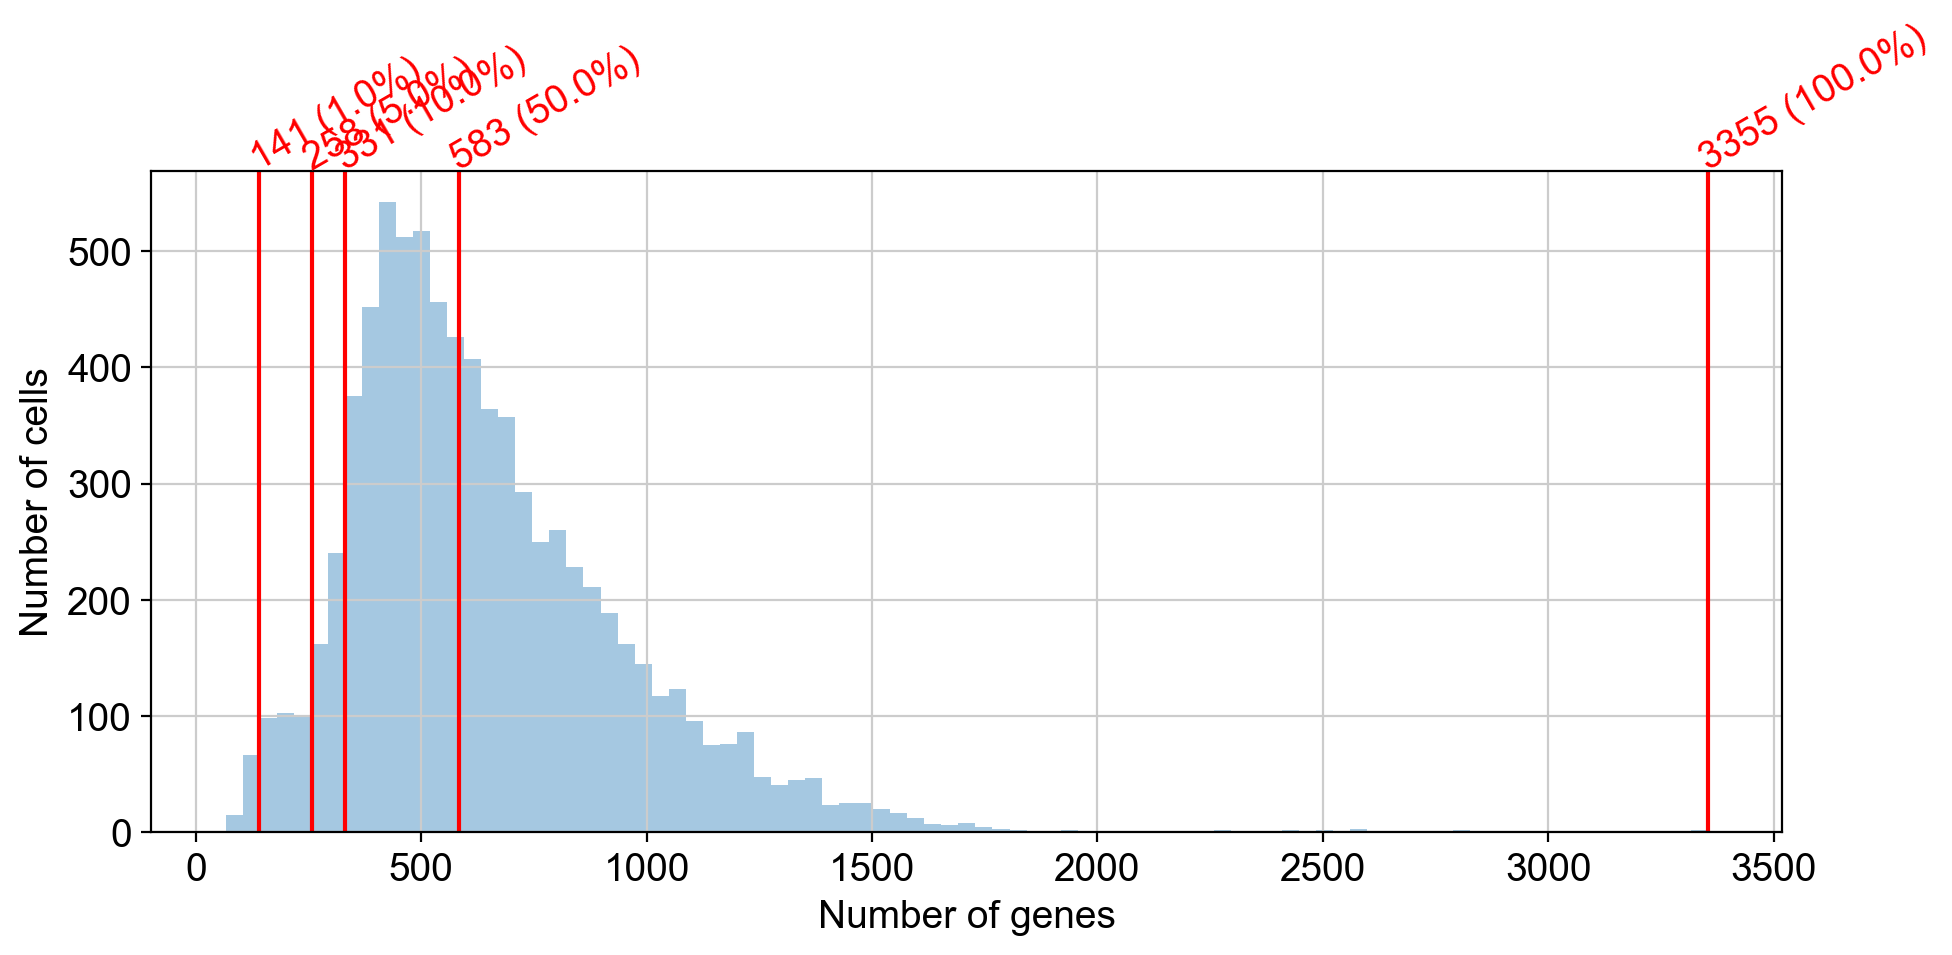

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='medium', rotation_mode='anchor')
ax.set_xlabel('Number of genes')
ax.set_ylabel('Number of cells')
plt.tight_layout()

In [38]:
%%time
!pyscenic aucell \
    {f_loom_path_scenic} \
    {REGULONS_DAT_FNAME} \
    --output {AUCELL_MTX_FNAME} \
    --num_workers 16

Wall time: 44.8 s



2022-02-14 04:26:35,079 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-02-14 04:26:36,282 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2022-02-14 04:26:36,282 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2022-02-14 04:27:11,993 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [39]:
auc_mtx = pd.read_csv(AUCELL_MTX_FNAME, index_col=0)
auc_mtx

Ahr        Ar      Arnt  \
Cell                                                                          
sample_alignments_MGD8A:AAGTTCGAGTGTTCCAx-CKP  0.024996  0.000000  0.000000   
sample_alignments_MGD8A:AACAAGAAGGATACATx-CKP  0.016926  0.043579  0.002088   
sample_alignments_MGD8A:AATAGAGTCTCGACGGx-CKP  0.013352  0.000000  0.000000   
sample_alignments_MGD8A:AATTCCTCAAAGCGTGx-CKP  0.015627  0.000000  0.000000   
sample_alignments_MGD8A:AACCAACAGACTTCACx-CKP  0.021035  0.000000  0.000000   
...                                                 ...       ...       ...   
sample_alignments_ULYRA:TTTGGAGTCGAAACAAx-KO   0.022219  0.050738  0.018245   
sample_alignments_ULYRA:TTTGGTTTCTCATGGAx-KO   0.018661  0.000000  0.016654   
sample_alignments_ULYRA:TTTGTTGCATTGAAAGx-KO   0.030278  0.056376  0.042158   
sample_alignments_ULYRA:TTTGGTTCACCAACATx-KO   0.015442  0.000000  0.000000   
sample_alignments_ULYRA:TTTGACTGTGAAAGTTx-KO   0.023386  0.000000  0.000000   

                                                   Atf1      Atf3      Atf4  \
Cell                                                                          
sample_alignments_MGD8A:AAGTTCGAGTGTTCCAx-CKP  0.027372  0.063477  0.046163   
sample_alignments_MGD8A:AACAAGAAGGATACATx-CKP  0.029411  0.053614  0.040463   
sample_alignments_MGD8A:AATAGAGTCTCGACGGx-CKP  0.024076  0.053026  0.045968   
sample_alignments_MGD8A:AATTCCTCAAAGCGTGx-CKP  0.025282  0.068979  0.062037   
sample_alignments_MGD8A:AACCAACAGACTTCACx-CKP  0.037227  0.068903  0.095030   
...                                                 ...       ...       ...   
sample_alignments_ULYRA:TTTGGAGTCGAAACAAx-KO   0.034984  0.062216  0.044898   
sample_alignments_ULYRA:TTTGGTTTCTCATGGAx-KO   0.012726  0.064388  0.054586   
sample_alignments_ULYRA:TTTGTTGCATTGAAAGx-KO   0.044499  0.034005  0.035833   
sample_alignments_ULYRA:TTTGGTTCACCAACATx-KO   0.020899  0.065742  0.040346   
sample_alignments_ULYRA:TTTGACTGTGAAAGTTx-KO   0.042494  0.060883  0.059430   

                                                   Atf5      Atf6      Bdp1  \
Cell                                                                          
sample_alignments_MGD8A:AAGTTCGAGTGTTCCAx-CKP  0.038997  0.009314  0.023632   
sample_alignments_MGD8A:AACAAGAAGGATACATx-CKP  0.042185  0.000000  0.030262   
sample_alignments_MGD8A:AATAGAGTCTCGACGGx-CKP  0.039085  0.001452  0.023632   
sample_alignments_MGD8A:AATTCCTCAAAGCGTGx-CKP  0.029733  0.000000  0.030059   
sample_alignments_MGD8A:AACCAACAGACTTCACx-CKP  0.033107  0.000000  0.030262   
...                                                 ...       ...       ...   
sample_alignments_ULYRA:TTTGGAGTCGAAACAAx-KO   0.029239  0.000000  0.047549   
sample_alignments_ULYRA:TTTGGTTTCTCATGGAx-KO   0.032409  0.010382  0.030791   
sample_alignments_ULYRA:TTTGTTGCATTGAAAGx-KO   0.022148  0.017367  0.029856   
sample_alignments_ULYRA:TTTGGTTCACCAACATx-KO   0.046167  0.000000  0.039496   
sample_alignments_ULYRA:TTTGACTGTGAAAGTTx-KO   0.036515  0.000000  0.029856   

                                                Bhlhe41  ...     Trp63  \
Cell                                                     ...             
sample_alignments_MGD8A:AAGTTCGAGTGTTCCAx-CKP  0.053318  ...  0.000000   
sample_alignments_MGD8A:AACAAGAAGGATACATx-CKP  0.076435  ...  0.003295   
sample_alignments_MGD8A:AATAGAGTCTCGACGGx-CKP  0.053318  ...  0.076632   
sample_alignments_MGD8A:AATTCCTCAAAGCGTGx-CKP  0.053393  ...  0.016840   
sample_alignments_MGD8A:AACCAACAGACTTCACx-CKP  0.065399  ...  0.000000   
...                                                 ...  ...       ...   
sample_alignments_ULYRA:TTTGGAGTCGAAACAAx-KO   0.056152  ...  0.049664   
sample_alignments_ULYRA:TTTGGTTTCTCATGGAx-KO   0.078896  ...  0.000000   
sample_alignments_ULYRA:TTTGTTGCATTGAAAGx-KO   0.000000  ...  0.000000   
sample_alignments_ULYRA:TTTGGTTCACCAACATx-KO   0.054661  ...  0.000000   
sample_alignments_ULYRA:TTTGACTGTGAAAGTTx-KO   0.054437  ...  0.059426   

     

In [40]:
# STEP 5 - Regulon activity binarization

In [41]:
%%time
binary_mtx, thresholds = binarize(auc_mtx)
binary_mtx.to_csv(BINARY_MTX_FNAME)
thresholds.to_frame().rename(columns={0:'threshold'}).to_csv(THR_FNAME)

Wall time: 4min 48s


In [42]:
binary_mtx = pd.read_csv(BINARY_MTX_FNAME, index_col=0)
binary_mtx

Ahr  Ar  Arnt  Atf1  Atf3  \
Cell                                                                       
sample_alignments_MGD8A:AAGTTCGAGTGTTCCAx-CKP    0   0     0     0     0   
sample_alignments_MGD8A:AACAAGAAGGATACATx-CKP    0   1     0     0     0   
sample_alignments_MGD8A:AATAGAGTCTCGACGGx-CKP    0   0     0     0     0   
sample_alignments_MGD8A:AATTCCTCAAAGCGTGx-CKP    0   0     0     0     0   
sample_alignments_MGD8A:AACCAACAGACTTCACx-CKP    0   0     0     0     0   
...                                            ...  ..   ...   ...   ...   
sample_alignments_ULYRA:TTTGGAGTCGAAACAAx-KO     0   1     1     0     0   
sample_alignments_ULYRA:TTTGGTTTCTCATGGAx-KO     0   0     1     0     0   
sample_alignments_ULYRA:TTTGTTGCATTGAAAGx-KO     0   1     1     0     0   
sample_alignments_ULYRA:TTTGGTTCACCAACATx-KO     0   0     0     0     0   
sample_alignments_ULYRA:TTTGACTGTGAAAGTTx-KO     0   0     0     0     0   

                                               Atf4  Atf5  Atf6  Bdp1  \
Cell                                                                    
sample_alignments_MGD8A:AAGTTCGAGTGTTCCAx-CKP     0     0     0     0   
sample_alignments_MGD8A:AACAAGAAGGATACATx-CKP     0     0     0     0   
sample_alignments_MGD8A:AATAGAGTCTCGACGGx-CKP     0     0     0     0   
sample_alignments_MGD8A:AATTCCTCAAAGCGTGx-CKP     0     0     0     0   
sample_alignments_MGD8A:AACCAACAGACTTCACx-CKP     1     0     0     0   
...                                             ...   ...   ...   ...   
sample_alignments_ULYRA:TTTGGAGTCGAAACAAx-KO      0     0     0     1   
sample_alignments_ULYRA:TTTGGTTTCTCATGGAx-KO      0     0     0     0   
sample_alignments_ULYRA:TTTGTTGCATTGAAAGx-KO      0     0     1     0   
sample_alignments_ULYRA:TTTGGTTCACCAACATx-KO      0     0     0     1   
sample_alignments_ULYRA:TTTGACTGTGAAAGTTx-KO      0     0     0     0   

                                               Bhlhe41  ...  Trp63  Usf2  Yy1  \
Cell                                                    ...                     
sample_alignments_MGD8A:AAGTTCGAGTGTTCCAx-CKP        0  ...      0     0    0   
sample_alignments_MGD8A:AACAAGAAGGATACATx-CKP        0  ...      0     0    0   
sample_alignments_MGD8A:AATAGAGTCTCGACGGx-CKP        0  ...      1     0    0   
sample_alignments_MGD8A:AATTCCTCAAAGCGTGx-CKP        0  ...      0     0    0   
sample_alignments_MGD8A:AACCAACAGACTTCACx-CKP        0  ...      0     0    0   
...                                                ...  ...    ...   ...  ...   
sample_alignments_ULYRA:TTTGGAGTCGAAACAAx-KO         0  ...      1     0    0   
sample_alignments_ULYRA:TTTGGTTTCTCATGGAx-KO         0  ...      0     0    0   
sample_alignments_ULYRA:TTTGTTGCATTGAAAGx-KO         0  ...      0     0    0   
sample_alignments_ULYRA:TTTGGTTCACCAACATx-KO         0  ...      0     0    0   
sample_alignments_ULYRA:TTTGACTGTGAAAGTTx-KO         0  ...      1     0    0   

                                               Zfp236  Zfp263  Zfp341  Zfp358  \
Cell                                                                            
sample_alignments_MGD8A:AAGTTCGAGTGTTCCAx-CKP       0       0       0       0   
sample_alignments_MGD8A:AACAAGAAGGATACATx-CKP       1       0       0       0   
sample_alignments_MGD8A:AATAGAGTCTCGACGGx-CKP       0       0       0       0   
sample_alignments_MGD8A:AATTCCTCAAAGCGTGx-CKP       1       0       0       0   
sample_alignments_MGD8A:AACCAACAGACTTCACx-CKP       1       0       0       0   
...                                               ...     ...     ...     ...   
sample_alignments_ULYRA:TTTGGAGTCGAAACAAx-KO        0       0       0       1   
sample_alignments_ULYRA:TTTGGTTTCTCATGGAx-KO        1       0       1       0   
sample_alignments_ULYRA:TTTGTTGCATTGAAAGx-KO        0       0       1       0   
sample_alignments_ULYRA:TTTGGTTCACCAACATx-KO        0       0       0       0   
sample_alignments_ULYRA:TTTGACTGTGAAAGTTx-KO        1       0       0       0   



In [43]:
thresholds = pd.read_csv(THR_FNAME, index_col=0).threshold
thresholds

Ahr        0.031494
Ar         0.016257
Arnt       0.016556
Atf1       0.045167
Atf3       0.086799
             ...   
Zfp341     0.025750
Zfp358     0.046099
Zfp386     0.017701
Zfp623     0.018452
Zfp729b    0.008372
Name: threshold, Length: 154, dtype: float64

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


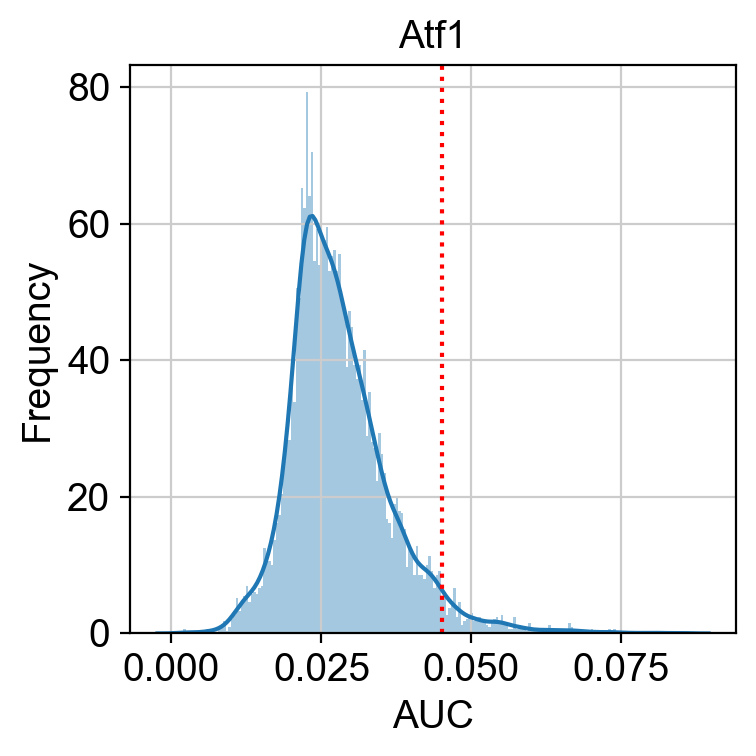

In [45]:
fig, ax = plt.subplots(1, 1)
plot_binarization(auc_mtx=auc_mtx, regulon_name='Atf1', threshold=thresholds['Atf1'])
ax.set_ylabel('Frequency')
plt.tight_layout()
savesvg('AUC_binarization - 4in1 - Atf1.svg', fig)

In [46]:
# Create heatmap with binarized regulon activity

In [47]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - 0.5)
    ax.set_yticks([-0.5, 0.5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [48]:
N_COLORS = len(adata.obs['batch'].dtype.categories)
COLORS = [color['color'] for color in mpl.rcParams["axes.prop_cycle"]]

In [49]:
batch_color_lut = dict(zip(adata.obs['batch'].dtype.categories, COLORS))
CellID_to_batch_lut = adata.obs['batch'].to_dict()
white_black_palette = sns.xkcd_palette(["white", "black"])

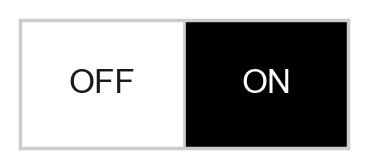

In [50]:
sns.set()
sns.set_style("whitegrid")
fig = palplot(white_black_palette, ['OFF', 'ON'], ['k', 'w'])
savesvg('legend - 4in1 - on_off.svg', fig)

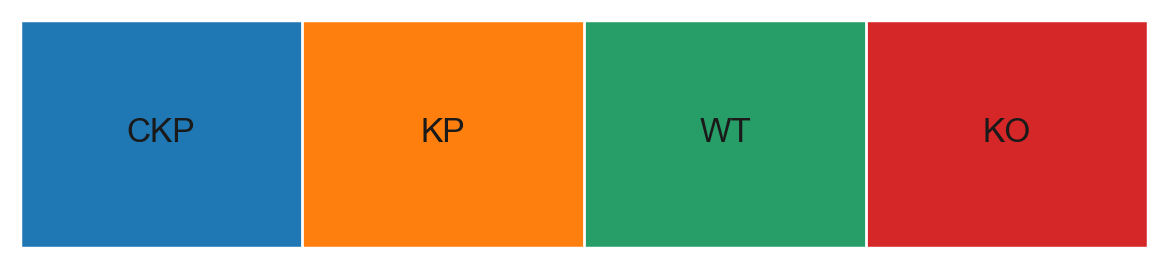

In [51]:
sns.set()
sns.set(font_scale=1)
fig = palplot(sns.color_palette(COLORS, n_colors=N_COLORS), adata.obs['batch'].dtype.categories, size=1.5)
savesvg('legend - 4in1 - batch_colors.svg', fig)

C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


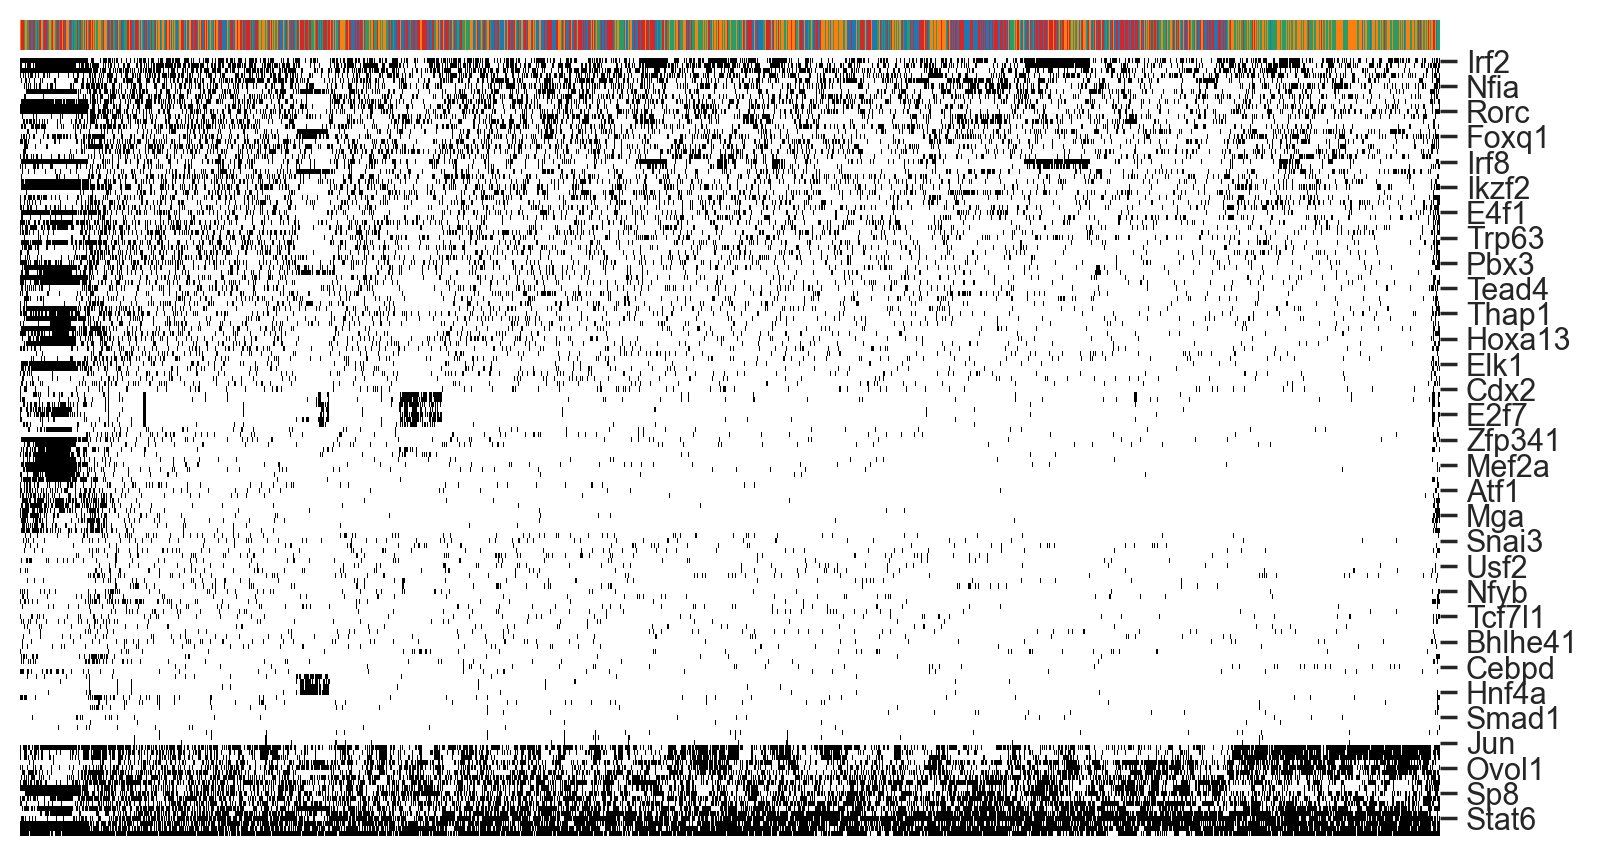

In [52]:
sns.set()
sns.set(font_scale=1)    # if do not reset later, this font size will affect all downstream plotting
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(data=binary_mtx.T, figsize=(10,10),
                   col_colors=auc_mtx.index.map(CellID_to_batch_lut).map(batch_color_lut),
                   cmap=white_black_palette)
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('')
g.ax_heatmap.set_ylabel('')
g.ax_col_colors.set_yticklabels([])
g.ax_col_colors.set_yticks([])
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_visible(False)
g.fig.savefig(os.path.join(FIGURES_FOLDERNAME, 'clustermap - 4in1.pdf'), format='pdf')

In [53]:
# Save clustered binarized heatmap to Excel for further inspection
binary_mtx_clustered = binary_mtx.T.copy()
binary_mtx_clustered.rename(columns=adata.obs['batch'].to_dict(), inplace=True)
binary_mtx_clustered.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind].to_excel(os.path.join(RESULTS_FOLDERNAME, '4in1_Binarized regulon activity.xlsx'))

In [54]:
# Generate sequence logos
def fetch_logo(regulon, base_url = BASE_URL):
    for elem in regulon.context:
        if elem.endswith('.png'):
            return '<img src="{}{}" style="max-height:124px;"></img>'.format(base_url, elem)
    return ""

In [55]:
df_regulons = pd.DataFrame(data=[list(map(op.attrgetter('name'), regulons)),
                                 list(map(len, regulons)),
                                 list(map(fetch_logo, regulons))], index=['name', 'count', 'logo']).T

In [56]:
df_regulons.to_csv("C:/Users/Park_Lab/Documents/MSO_4in1/MSO_4in1_motifs.csv")    # export the download addresses of motif logos

In [57]:
MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
display(HTML(df_regulons.head().to_html(escape=False)))    # display head of all regulons
display(HTML(df_regulons.loc[df_regulons['name'].isin(['Aqp5'])].to_html(escape=False)))    # display the wanted regulons
pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

C:\Users\Park_Lab\AppData\Local\Temp/ipykernel_14212/388861623.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [58]:
# STEP 6: Non-linear projection and clustering

In [59]:
# We capture the non-linear projection based on PCA+umap for later storage in the loom file.
embedding_pca_umap = pd.DataFrame(adata.obsm['X_umap'], columns=[['_X', '_Y']], index=adata.obs_names)

In [60]:
adata

AnnData object with n_obs × n_vars = 7867 × 5000
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rpl', 'pct_counts_rpl', 'total_counts_rps', 'pct_counts_rps', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'rpl', 'rps', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'batch_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [61]:
# We add all metadata derived from SCENIC to the Scanpy AnnData object.
add_scenic_metadata(adata, auc_mtx, regulons)
adata.write_h5ad(ANNDATA_FNAME)

In [62]:
adata

AnnData object with n_obs × n_vars = 7867 × 5000
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rpl', 'pct_counts_rpl', 'total_counts_rps', 'pct_counts_rps', 'leiden', 'Regulon(Ahr)', 'Regulon(Ar)', 'Regulon(Arnt)', 'Regulon(Atf1)', 'Regulon(Atf3)', 'Regulon(Atf4)', 'Regulon(Atf5)', 'Regulon(Atf6)', 'Regulon(Bdp1)', 'Regulon(Bhlhe41)', 'Regulon(Brca1)', 'Regulon(Cdx2)', 'Regulon(Cebpa)', 'Regulon(Cebpd)', 'Regulon(Creb5)', 'Regulon(Cux1)', 'Regulon(Deaf1)', 'Regulon(Dus3l)', 'Regulon(E2f1)', 'Regulon(E2f2)', 'Regulon(E2f3)', 'Regulon(E2f4)', 'Regulon(E2f6)', 'Regulon(E2f7)', 'Regulon(E2f8)', 'Regulon(E4f1)', 'Regulon(Egr1)', 'Regulon(Elf1)', 'Regulon(Elk1)', 'Regulon(Ep300)', 'Regulon(Esrra)', 'Regulon(Ets1)', 'Regulon(Etv3)', 'Regulon(Etv4)', 'Regulon(Etv5)', 'Regulon(Etv6)', 'Regulon(Fos)', 'Regulon(Fosl2)', 'Regulon(Foxa2)', 'Regulon(Foxa3)', 'Regulon(Foxf2)', 'Regulon(Foxn2)', 'Regulon(Foxo6)', 'Regulon(Foxq1)', '

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


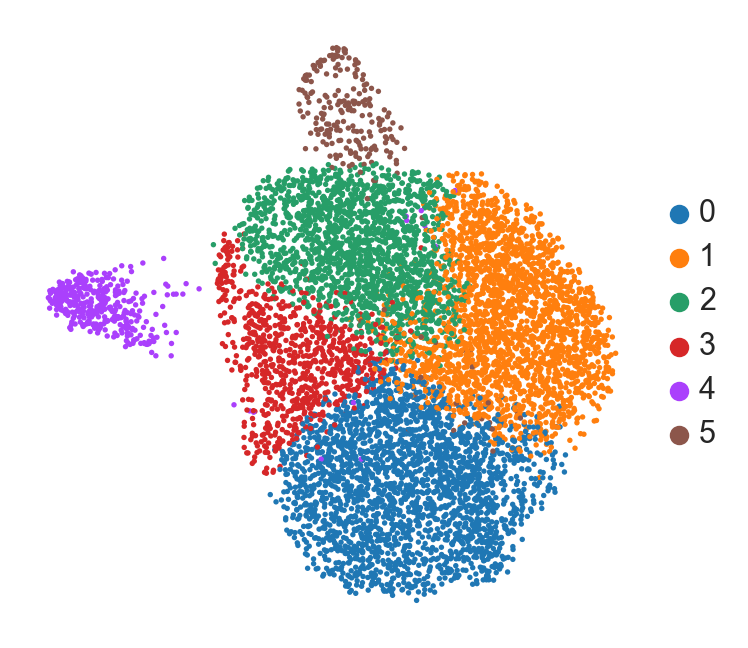

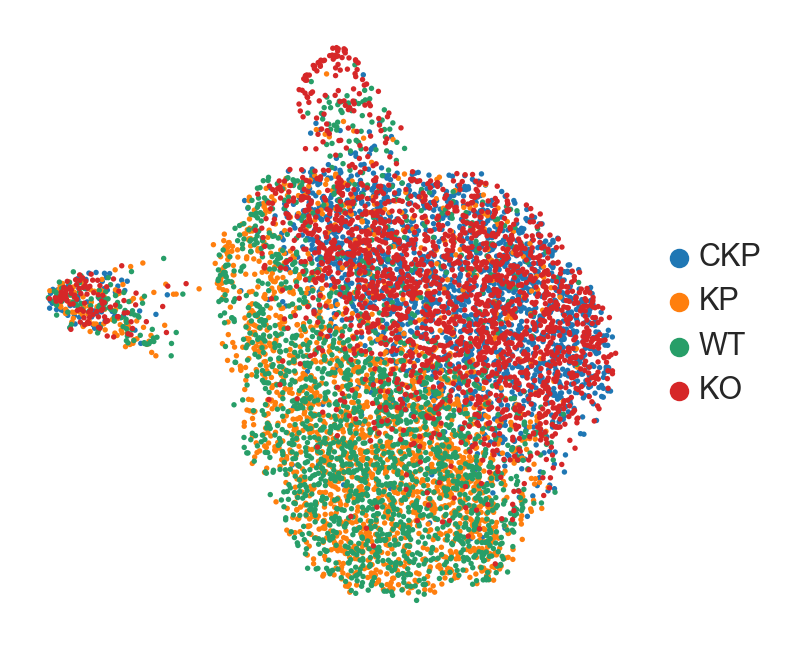

In [63]:
# AUCELL + umap PROJECTION
# We change the umap projection so that it relies on AUCell instead of PCA. Cells with similar regulons will cluster together.
sc.pp.neighbors(adata, n_pcs=50, knn=True, use_rep='X_aucell')
sc.tl.leiden(adata, resolution=0.5)    # this 'leiden' is calculated by aucell
sc.tl.umap(adata)
embedding_aucell_umap = pd.DataFrame(adata.obsm['X_umap'], columns=[['_X', '_Y']], index=adata.obs_names)
sc.pl.umap(adata, color=['leiden'], use_raw=False, frameon=False, legend_loc='right margin', title='', save=' - 4in1 - AUCell_umap.svg')
sc.pl.umap(adata, color=['batch'], use_raw=False, frameon=False, legend_loc='right margin', title='', save=' - 4in1 - batch_umap.svg')

In [64]:
# CELL TYPE SPECIFIC REGULATORS - Z-SCORE
df_obs = adata.obs
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
df_scores = df_obs[signature_column_names + ['batch']]
df_results = ((df_scores.groupby(by='batch').mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['Regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
df_results[(df_results.Z >= 0.5)].sort_values(['batch', 'Z'], ascending=False).to_csv('C:/Users/Park_Lab/Documents/MSO_4in1/2022.2.13_MSO_4in1_regulons.csv')

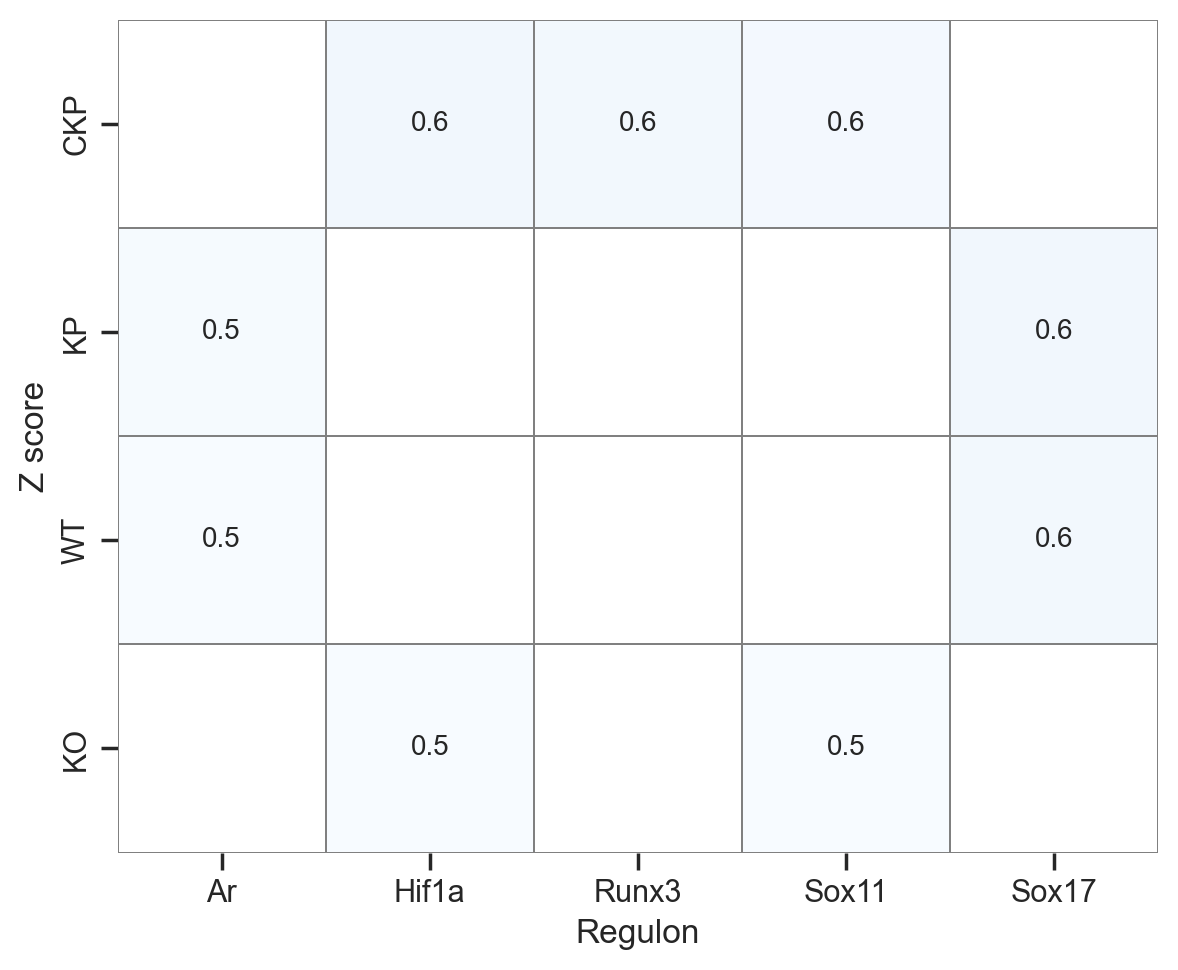

In [65]:
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= 0.5].sort_values('Z', ascending=False),
                           index='batch', columns='Regulon', values='Z')
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
sns.heatmap(df_heatmap, ax=ax, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            vmax=3, cmap="Blues", annot_kws={"size": 10})
ax.set_ylabel('Z score')
savesvg('heatmap - 4in1 - regulons.svg', fig)

In [66]:
# CELL TYPE SPECIFIC REGULATORS - RSS
rss = regulon_specificity_scores(auc_mtx, adata.obs['batch'])
rss.T.to_csv('C:/Users/Park_Lab/Documents/MSO_4in1/2022.2.13 RSS.csv')

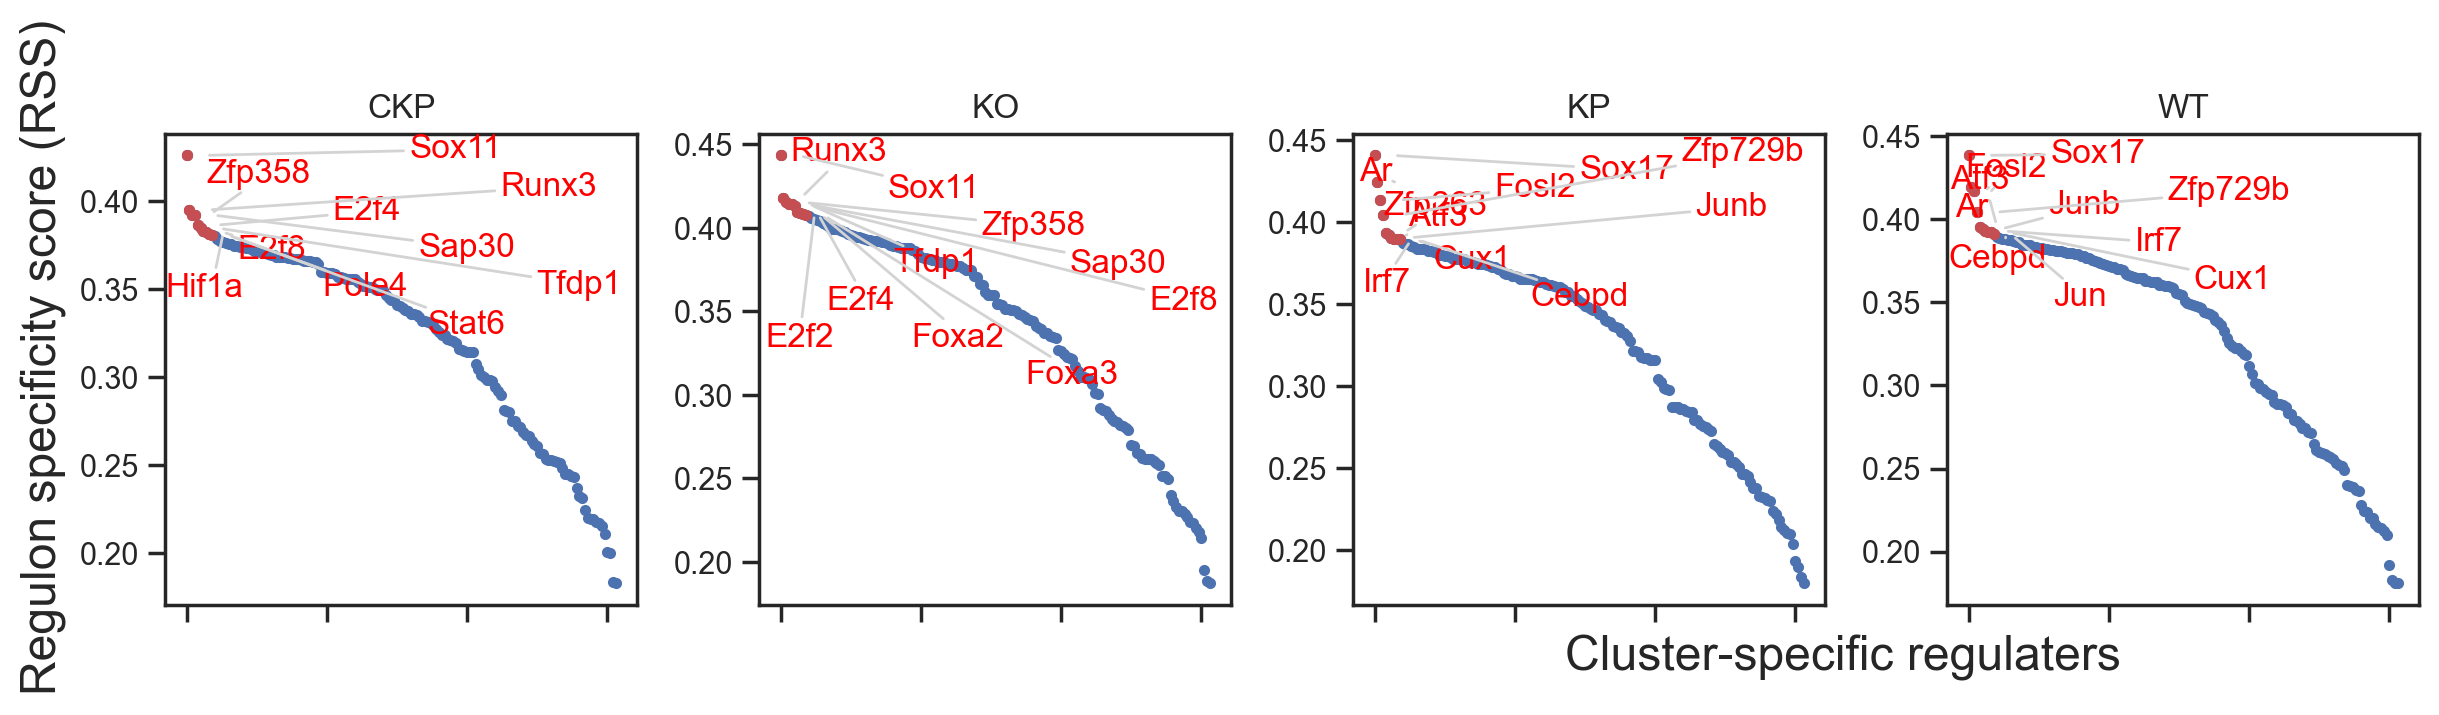

In [67]:
cats = sorted(list(set(adata.obs['batch'])))

fig = plt.figure(figsize=(18, 3))    # 3 is the total height of 1 row
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss.T[c]
    ax = fig.add_subplot(1,6,num)    # 1 means 1 row, 5 means 5 column
    plot_rss(rss, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05)
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001)
 
fig.text(0.5, 0.0, 'Cluster-specific regulaters', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large',
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
savesvg('plots - 4in1 - rss.svg', fig)
plt.show()

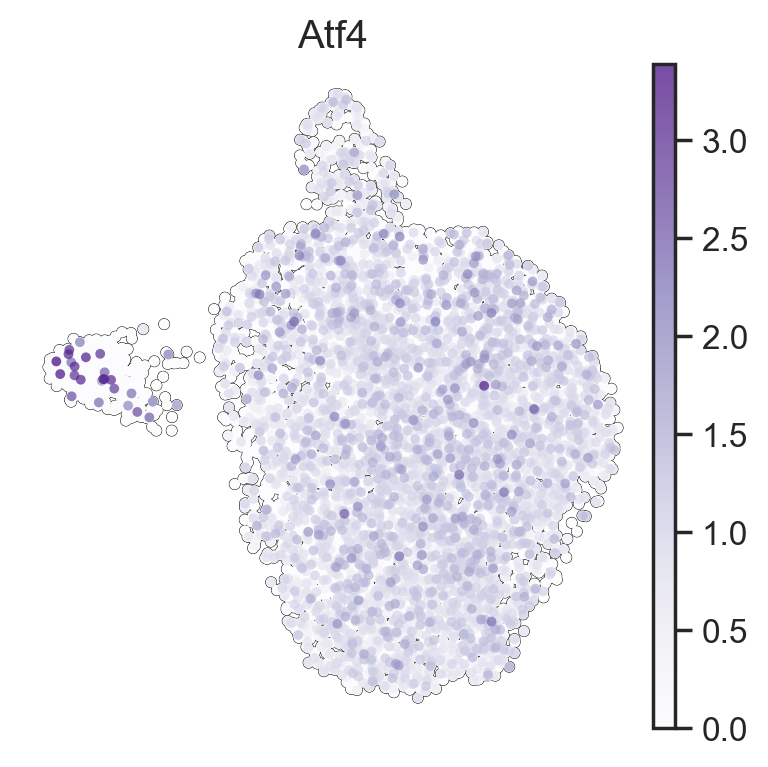

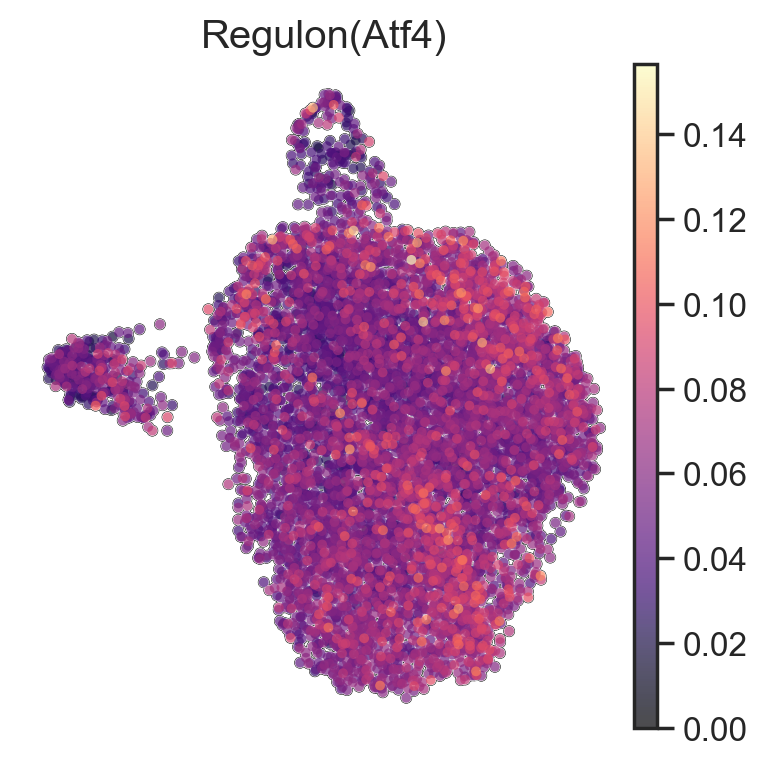

In [68]:
sc.pl.umap(adata, color=['Atf4'], use_raw=True, cmap='Purples', size=50,
           frameon=False, vmin=0, add_outline=True, outline_width=(0.05,0.05), save='- rss_Atf4_TF.svg')
sc.pl.umap(adata, color=['Regulon(Atf4)'], use_raw=True, cmap='magma', size=50,
           frameon=False, vmin=0, add_outline=True, outline_width=(0.05,0.05), save=' - rss_Atf4_TF_regulon.svg')

In [69]:
# AUCELL DISTRIBUTIONS
# We can also analyze the distribution of AUCell values via the plots in the scanpy package.
df_results.sort_values('Z', ascending=False).groupby(by='batch').head(5)

batch           regulon         Z  Regulon
52    CKP    Regulon(Hif1a)  0.588867    Hif1a
275    KP    Regulon(Sox17)  0.586451    Sox17
112   CKP    Regulon(Runx3)  0.570700    Runx3
429    WT    Regulon(Sox17)  0.564020    Sox17
120   CKP    Regulon(Sox11)  0.555946    Sox11
155    KP       Regulon(Ar)  0.524130       Ar
582    KO    Regulon(Sox11)  0.505520    Sox11
309    WT       Regulon(Ar)  0.504315       Ar
514    KO    Regulon(Hif1a)  0.503324    Hif1a
574    KO    Regulon(Runx3)  0.496541    Runx3
191    KP    Regulon(Fosl2)  0.483893    Fosl2
345    WT    Regulon(Fosl2)  0.481495    Fosl2
158    KP     Regulon(Atf3)  0.475088     Atf3
312    WT     Regulon(Atf3)  0.423948     Atf3
21    CKP     Regulon(E2f4)  0.413246     E2f4
150   CKP   Regulon(Zfp358)  0.406262   Zfp358
307    KP  Regulon(Zfp729b)  0.388398  Zfp729b
576    KO    Regulon(Sap30)  0.386093    Sap30
612    KO   Regulon(Zfp358)  0.370356   Zfp358
461    WT  Regulon(Zfp729b)  0.368277  Zfp729b

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_batch']`


C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\scanpy\plotting\_utils.py:288: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
C:\Users\Park_Lab\anaconda3\envs\HYJ_py38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


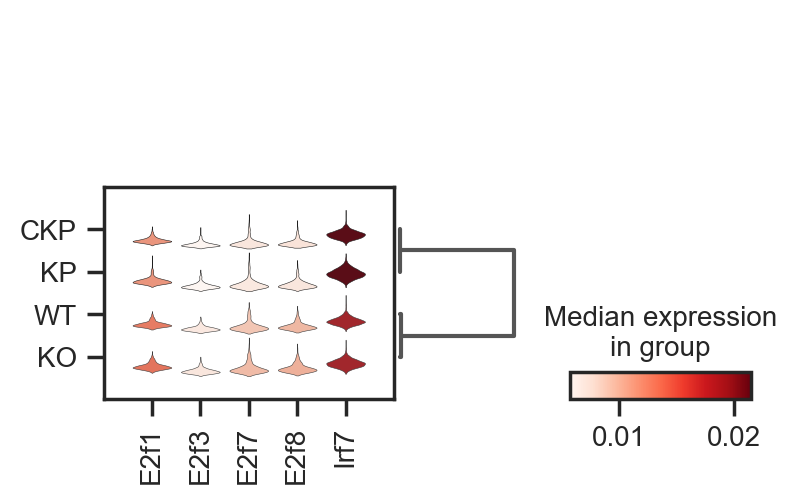

In [70]:
aucell_adata = sc.AnnData(X=auc_mtx.sort_index())
aucell_adata.obs = df_obs
names = list(map(op.attrgetter('name'), filter(lambda r: r.score > 8.0, regulons)))
sc.pl.stacked_violin(aucell_adata, names, groupby='batch', use_raw=False, dendrogram=True, save=' - 4in1 - regulons.svg', cmap='Reds')

In [ ]:
# STEP 7: Export to SCope

In [ ]:
export2loom(ex_mtx=adata.to_df(), regulons=regulons, out_fname=LOOM_FNAME,
            cell_annotations=adata.obs['batch'].to_dict(), tree_structure=(),
            title='{}_{}'.format(TCGA_CODE, DATASET_ID), nomenclature="mm10", num_workers=16,
            embeddings=OrderedDict([('AUCell + umap', embedding_aucell_umap), ('PCA + umap', embedding_pca_umap)]),
            auc_mtx = auc_mtx, auc_thresholds=thresholds,
            compress=True)

In [ ]:
# Step 8: Cytoscape-iRegulon exploration of modules

In [ ]:
adjacencies = pd.read_csv(ADJACENCIES_FNAME, index_col=False, sep='\t')
adjacencies

In [ ]:
# Create the modules
from pyscenic.utils import modules_from_adjacencies
lf = lp.connect(f_loom_path_scenic, mode='r', validate=False)
exprMat = pd.DataFrame(lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
modules = list(modules_from_adjacencies(adjacencies, exprMat))
lf.close()

In [ ]:
# create a dictionary of regulons for converting the index from string to values:
lf2 = lp.connect(LOOM_FNAME, mode='r', validate=False)
regulons_dict = {}
for i,r in pd.DataFrame(lf2.ra.Regulons, index=lf2.ra.Gene).iteritems():
    regulons_dict[i] =  list(r[r==1].index.values)
lf2.close()

In [ ]:
# pick out modules for Atoh1
tf = 'Sox4'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons_dict[tf])} genes' )

In [ ]:
# write these modules, and the regulon to files
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons_dict[tf]:
        f.write("%s\n" % item)

In [ ]:
# Step 9: Cytoscape-iRegulon